# HUD Section 8 Housing Fairness Assessment
### ADTA 5940 Capstone Project
Marissa McKee

In [1]:
# !pip install sklearn
# !pip install xgboost
# !pip install aif360
# !pip install wrapt
# !pip install fairlearn
# !pip install BlackBoxAuditing
# !pip install lime
# !pip install -U imbalanced-learn
# !conda install -c conda-forge imbalanced-learn

In [2]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier


import aif360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import disparate_impact_ratio, statistical_parity_difference
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


import shap

C:\Users\mckee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mckee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mckee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mckee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# 1. HUD Housing Data
### Data Source: 
- https://www.huduser.gov/apps/public/pums/home

### Use of HUD:
The PUMS contains separate datasets for households assisted by programs administered by HUD’s Office of Public and Indian Housing (PIH) and Office of Housing. Data for two of the largest PIH programs are provided: Public Housing, and the Housing Choice Voucher program (HCVP), as are data on three Office of Housing multifamily programs: Project Based Section 8, Section 202, and Section 811.

HCVP tenants find rental units in the private market, paying at least 30 percent of their income toward rent and utilities, with the remainder subsidized by a HUD voucher. Public Housing tenants live in housing owned and operated by public housing agencies. Project Based Section 8 tenants live in privately owned and operated developments, where some or all of the housing units are HUD subsidized. Section 202 subsidizes supportive housing for the elderly, and Section 811 subsidizes supportive housing for persons with disabilities.

The data used for model development and the subsequent fairness assessment includes attributes from a dataset HUD maintains annually. The Public Use Microdata Sample (PUMS) datasets cover HUD's largest rental assistance programs: the Housing Choice Voucher Program, Public Housing, Project-based Section 8, and the Section 202/811 Programs. The datasets include demographic information like race, sex, income, family size, and geographic location. Please refer to the Data Dictionary for more information. The data is intended to be used by qualified researchers who must provide adequate information to be approved for use of the data. 

The PUMS datasets contains data collected from 2020 from the Office of Public and Indian Housing and the Office of Housing. The two sources of data were available in two separate data files. For the purpose of this project, I combined both sources for a better overall picture of HUD’s housing programs. 

In [3]:
df1 = pd.read_csv('HUD_Data_Clean_MF.csv')
df2 = pd.read_csv('HUD_Data_Clean_PIH.csv')

# Concat dataframes together
frames = [df1, df2]
df = pd.concat(frames)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158023 entries, 0 to 107998
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   prog      158023 non-null  object 
 1   state     158023 non-null  object 
 2   fipst     158023 non-null  int64  
 3   strata    158023 non-null  object 
 4   poverty   158023 non-null  object 
 5   ur        158023 non-null  object 
 6   metro     158023 non-null  object 
 7   h6        158023 non-null  int64  
 8   mbrs      158023 non-null  int64  
 9   bdrms     158023 non-null  int64  
 10  race_eth  158023 non-null  object 
 11  sex       158023 non-null  object 
 12  inc5000   158023 non-null  object 
 13  ainc5000  158023 non-null  object 
 14  brdn      158023 non-null  object 
 15  Weight    158023 non-null  float64
dtypes: float64(1), int64(4), object(11)
memory usage: 20.5+ MB


,prog,state,fipst,strata,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,Weight
0,Sec 202,Alabama,1,01_Sec 202,0%-9%,U,Metropolitan,1,1,1,White,F,"$12,501-$15,000","$12,501-$15,000",0%-31%,45.131579
1,Sec 202,Alabama,1,01_Sec 202,0%-9%,U,Metropolitan,1,1,1,White,F,"$20,001-$25,000","$15,001-$17,500",0%-31%,45.131579
2,Sec 202,Alabama,1,01_Sec 202,0%-9%,U,Metropolitan,1,1,1,White,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,45.131579
3,Sec 202,Alabama,1,01_Sec 202,10%-19%,U,Metropolitan,1,1,1,Black,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,45.131579
4,Sec 202,Alabama,1,01_Sec 202,10%-19%,U,Metropolitan,1,1,1,Black,M,"$7,501-$10,000","$7,501-$10,000",0%-31%,45.131579


# 1.1 HUD Data Dictionary
#### Program: 

-	"Program is identified by character variable “prog”. For Public Housing tenants, this variable equals “P”. For HCVP tenants, this variable equals “V”. For Project Based Section 8 tenants, this variable equals “Sec 8”. For Section 202 tenants, this variable equals “Sec 202”. For Section 811 tenants, this variable equals “Sec 811”. "

#### State:

-	States are identified by two character variables. Variable “state” contains the mixed-case state name, and variable “fipst” contains the state FIPS code. Missing or suppressed state names are set to “Z Missing”; missing or suppressed fips codes are set to “99”.

#### Strata:

-	Sampling strata are identified by variable “strata”, which is a concatenation of the state FIPS code (variable “fipst”) and program (variable “prog”).

#### Census Tract Poverty Rate: 

-	Census tract poverty rates are measured by character variable “poverty”. Poverty rates for 2009 and 2010 PUMS are based on American Community Survey (ACS) data averaged over 2005-09, using 2000 tract boundaries. Poverty rates for 2012 PUMS are based on ACS data averaged over 2007-11, using 2010 tract boundaries. Poverty rates for 2013 PUMS are based on ACS data averaged over 2008-12, using 2010 tract boundaries. Poverty rates for 2014 PUMS are based on ACS data averaged over 2009-13, using 2010 tract boundaries. Poverty rates for 2015 PUMS are based on ACS data averaged over 2010-14, using 2010 tract boundaries. Poverty rates for 2016 are based on ACS data averaged over 2011-15, using 2010 tract boundaries. Poverty rates for 2017 are based on ACS data averaged over 2012-16, using 2010 tract boundaries. Poverty rates for 2018 are based on ACS data averaged over 2013-17, using 2010 tract boundaries. Poverty rates for 2019 are based on ACS data averaged over 2014-18, using 2010 tract boundaries. Poverty rates for 2020 are based on ACS data averaged over 2014-18, using 2010 tract boundaries. Poverty rates are reported in four five categories: 0%-9%, 10%-19%, 20%- 29%, 30%-39%, and 40% and above. Missing or suppressed values are blank.

#### Urban/Rural Status: 

-	Urban/rural status is measured by character variable “UR”. For urban areas, UR equals “U”. For rural areas, UR equals “R”. Missing or suppressed values are blank.

#### Metropolitan Status: 

-	Metropolitan status is measured by character variable “metro”. For metropolitan areas, metro equals “Metropolitan”. For micropolitan areas, metro equals “Micropolitan”. Non-metropolitan areas are defined as areas outside of Core Based Statistical Areas (CBSAs). For nonmetropolitan areas, metro equals “Non-CBSA”. Missing or suppressed values are blank.

#### Household Type: 

-	Household type is measured by character variable “H6”. H6 equals “1” for households with an elderly head or spouse, and no children. H6 equals “2” for non-elderly households where the head or spouse has disabilities, and there are no children. H6 equals “3” for other households with no children. H6 equals “4” for households with an elderly head or spouse, with children. H6 equals “5” for non-elderly households where the head or spouse has disabilities, with children present. H6 equals “6” for other households with children. Elderly is defined as age 62 and above.

#### Household Members:

-	Household member counts are measured by numeric variable “mbrs”, taking values of 1-7. Household members is top-coded at 7, thus 7 represents 7 or more householders. Missing or suppressed values are blank.

#### Bedrooms: 

-	Bedroom counts are measured by numeric variable “bdrms”, taking values of 0-4. Bedroom counts are top-coded at 4, thus 4 represents 4 or more bedrooms. Missing or suppressed values are blank.

#### Race/Ethnicity of Household Head: 

-	Race and ethnicity of the household head is measured by character variable “race_eth”. Race and ethnicity are reported in four categories. For Hispanics of any race, race_eth equals “Hispanic”. For non-Hispanic whites, race_eth equals “White”. For non-Hispanic blacks, race_eth equals “Black”. For other non-Hispanics, race_eth equals “Other”. Missing or suppressed values are blank.

#### Sex of Household Head:

-	Sex of household head is measured by character variable “sex”. Males are coded as “M”, and females are coded as “F”. Missing or suppressed values are blank.

#### Household Income: 

-	Annual household income is measured by character variable “inc5000”. The 2009 PUMS reports income in 13 categories. The first 12 categories report income in 5,000 increments: 0-5,000, 5001-10,000, up to 55,001-60,000. The thirteenth category is for households with income between 60,001 and 90,000. Income is top-coded at 90,000. Starting in 2010, the PUMS reports income in 12 categories. The first eight categories report income in 2,500 increments: 0-2,500, 2,501-5,000, 17,501-20,000. The next two categories report income in 5,000 increments: 20,001-25,000, and 25,001-30,000. The 11th category is for households with income between 30,001 and 40,000. The 12th category is for households with income between 40,001 and 90,000. Income is top-coded at 90,000.

#### Adjusted Household Income: 

-	Eligibility for HUD rental assistance programs is based on adjusted household income. Adjusted income is calculated by subtracting off certain expenses from household income. Details of the calculation for PIH programs are reported on HUD form 500585, and on HUD form 500596 for Office of Housing programs. Annual adjusted household income is reported in the same categories as annual household income, and is also top-coded at 90,000. Adjusted household annual income is measured by character variable “ainc5000”. Adjusted household annual income is reported in the same categories as annual household income, and is also top-coded at 90,000.

#### Rent Burden:

-	Rent burden is defined as gross rent (including utility costs) divided by monthly adjusted household income. Rent burden is undefined for households with 0 adjusted income. Rent burden is measured by character variable “brdn”. Rent burden is reported in four categories: 0%-31%, 32%-39%, 40%-49%, and 50% and above.

#### Survey Weight:

-	The survey weight is measured by variable “weight”, which is the inverse of the sampling probability. The weight is the same for all households in a given stratum.


In [4]:
df.shape
df.describe()

(158023, 16)

,fipst,h6,mbrs,bdrms,Weight
count,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000
mean,28.060681,2.760706,1.823045,1.664891,20.343972
std,15.106581,2.058665,1.256679,0.921867,6.473858
min,1.000000,1.000000,1.000000,0.000000,9.619048
25%,13.000000,1.000000,1.000000,1.000000,16.269697
50%,34.000000,2.000000,1.000000,1.000000,19.499097
75%,37.000000,5.000000,2.000000,2.000000,24.263705
max,72.000000,6.000000,7.000000,4.000000,81.571429


# 2. Transform into Binary Classification Problem
A new column that translates the tenants housing voucher status will be used as the binary target to classify tenants who are among the section 8 housing category. 

In [5]:
# Turn into a binary classification problem
df['sec_8']  = (df['prog']=='Sec 8').astype(int)

# 3. Feature Selection 

Not all features are useable. There are a number of reasons to remove features. Many of which are due to the relevancy they have on the final model. I will be removing the survey weight, strata, and fipst features. In this model, there is no need to track the sampling strata, which is a concatenation of the state FIPS code (variable “fipst”) and program (variable “prog”). The fipst contains the state FIPS code which is a redundant feature to keep if I keep the state feature. Finally, the survey weight is the inverse of the sampling probability, which is unecessary to keep in the final model because it could cause complexity. 

The prog feature will be removed because it is being used as the binary target variable which will classify tenants as having a section 8 housing voucher. 

After exploratory data analysis and data preparation, I will a closer look into the features that will be used for the final model. 

In [6]:
df.drop(columns=['Weight', 'strata', 'fipst', 'prog'], inplace=True)
df.head()

,state,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,sec_8
0,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$12,501-$15,000","$12,501-$15,000",0%-31%,0
1,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$20,001-$25,000","$15,001-$17,500",0%-31%,0
2,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,0
3,Alabama,10%-19%,U,Metropolitan,1,1,1,Black,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,0
4,Alabama,10%-19%,U,Metropolitan,1,1,1,Black,M,"$7,501-$10,000","$7,501-$10,000",0%-31%,0


# 4. Exploratory Data Analysis

In [7]:
df.shape
df.describe()
df.head()

(158023, 13)

,h6,mbrs,bdrms,sec_8
count,158023.000000,158023.000000,158023.000000,158023.000000
mean,2.760706,1.823045,1.664891,0.296242
std,2.058665,1.256679,0.921867,0.456600
min,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,1.000000,0.000000
75%,5.000000,2.000000,2.000000,1.000000
max,6.000000,7.000000,4.000000,1.000000


,state,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,sec_8
0,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$12,501-$15,000","$12,501-$15,000",0%-31%,0
1,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$20,001-$25,000","$15,001-$17,500",0%-31%,0
2,Alabama,0%-9%,U,Metropolitan,1,1,1,White,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,0
3,Alabama,10%-19%,U,Metropolitan,1,1,1,Black,F,"$7,501-$10,000","$7,501-$10,000",0%-31%,0
4,Alabama,10%-19%,U,Metropolitan,1,1,1,Black,M,"$7,501-$10,000","$7,501-$10,000",0%-31%,0


#### Correlation Matrix
Higher COMPAS scores are slightly correlated with a longer length of stay.

In [8]:
df.corr()

,h6,mbrs,bdrms,sec_8
h6,1.000000,0.763128,0.657580,-0.154215
mbrs,0.763128,1.000000,0.743418,-0.177442
bdrms,0.657580,0.743418,1.000000,-0.247139
sec_8,-0.154215,-0.177442,-0.247139,1.000000


#### Correlation Plot
This may show us relationships between protected attributes or variables masked as proxies for those protected attribtues.

<Figure size 1080x576 with 0 Axes>

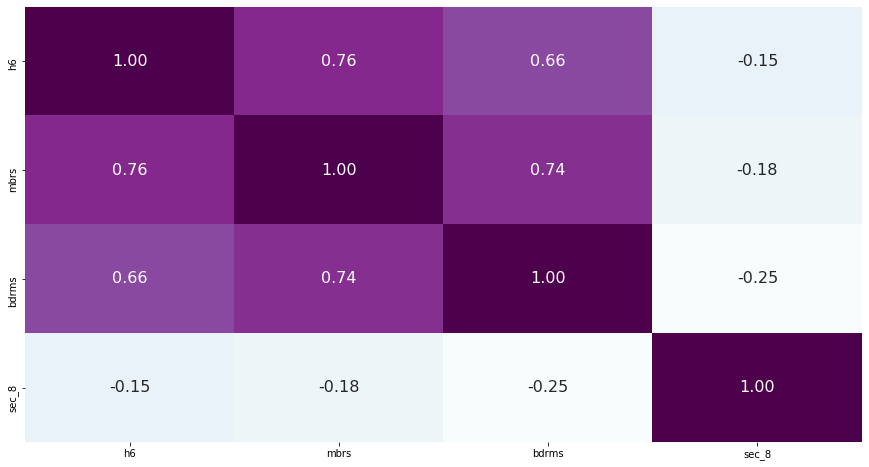

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),
           cmap='BuPu',
           annot=True,
           fmt=".2f",
           annot_kws={'size':16},
           cbar=False)

#### Check Correlations among Variables

In [10]:
correlations = df.corr()
correlations.replace(1,0).idxmax()

h6        mbrs
mbrs        h6
bdrms     mbrs
sec_8    sec_8
dtype: object

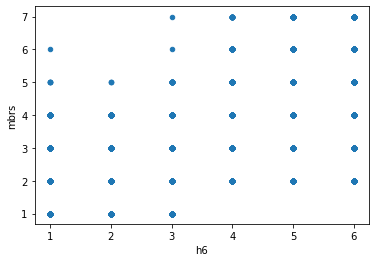

In [11]:
df[['h6','mbrs']].plot.scatter('h6','mbrs')

#### Check for Categorical Variables

In [12]:
cat_cols = df.loc[:,df.dtypes=='object'].columns
for column in cat_cols:
    print('Unique Values in ', column, df[column].unique())
    print(df[column].value_counts())

Unique Values in  state ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Puerto Rico']
New York                32725
California              21818
Massachusetts            8843
Texas                    7394
Illinois                 7136
New Jersey               6836
Pennsylvania             6641
Ohio                     5850
Florida                  5789
Michigan                 3650
Georgia                  3528
Maryland                 35

#### State Categories
After filtering the dataset, below is the following breakdown of different state's:

New York                32725
California              21818
Massachusetts            8843
Texas                    7394
Illinois                 7136
New Jersey               6836
Pennsylvania             6641
Ohio                     5850
Florida                  5789
Michigan                 3650
Georgia                  3528
Maryland                 3509
Virginia                 2963
Connecticut              2866
Washington               2838
Minnesota                2741
North Carolina           2628
Tennessee                2572
Alabama                  1960
Louisiana                1944
Indiana                  1934
Missouri                 1917
Wisconsin                1658
Kentucky                 1514
South Carolina           1388
Colorado                 1384
Puerto Rico              1338
District of Columbia     1266
Oregon                   1106
Mississippi              1037
Rhode Island             1021
Arizona                   820
Oklahoma                  801
Arkansas  

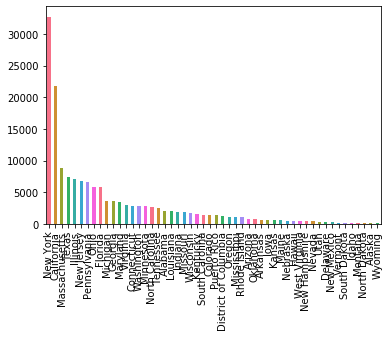

In [13]:
print(df['state'].value_counts())
print(df['state'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Poverty Categories
Census tract poverty rates are measured by character variable “poverty”. Poverty rates for 2009 and 2010 PUMS are based on American Community Survey (ACS) data averaged over 2005-09, using 2000 tract boundaries. Poverty rates for 2012 PUMS are based on ACS data averaged over 2007-11, using 2010 tract boundaries. Poverty rates for 2013 PUMS are based on ACS data averaged over 2008-12, using 2010 tract boundaries. Poverty rates for 2014 PUMS are based on ACS data averaged over 2009-13, using 2010 tract boundaries. Poverty rates for 2015 PUMS are based on ACS data averaged over 2010-14, using 2010 tract boundaries. Poverty rates for 2016 are based on ACS data averaged over 2011-15, using 2010 tract boundaries. Poverty rates for 2017 are based on ACS data averaged over 2012-16, using 2010 tract boundaries. Poverty rates for 2018 are based on ACS data averaged over 2013-17, using 2010 tract boundaries. Poverty rates for 2019 are based on ACS data averaged over 2014-18, using 2010 tract boundaries. Poverty rates for 2020 are based on ACS data averaged over 2014-18, using 2010 tract boundaries. Poverty rates are reported in four five categories: 0%-9%, 10%-19%, 20%- 29%, 30%-39%, and 40% and above. Missing or suppressed values are blank.

After filtering the dataset, the poverty demographic break down: 

10%-19%          41784
20%-29%          39143
40% and above    29188
30%-39%          27616
0%-9%            20292
Name: poverty, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


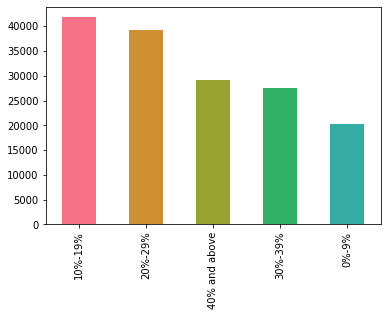

In [14]:
print(df['poverty'].value_counts())
print(df['poverty'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Urban and Rural Categories
Urban/rural status is measured by character variable “UR”. For urban areas, UR equals “U”. For rural areas, UR equals “R”. Missing or suppressed values are blank.

After filtering the dataset, the urban and rural groups break down: 

U    153844
R      4179
Name: ur, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


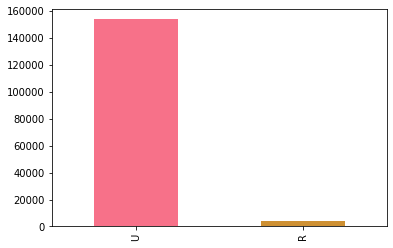

In [15]:
print(df['ur'].value_counts())
print(df['ur'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Metro Status Categories
Metropolitan status is measured by character variable “metro”. For metropolitan areas, metro equals “Metropolitan”. For micropolitan areas, metro equals “Micropolitan”. Non-metropolitan areas are defined as areas outside of Core Based Statistical Areas (CBSAs). For nonmetropolitan areas, metro equals “Non-CBSA”. Missing or suppressed values are blank.

After filtering the dataset, the metro groups break down: 

Metropolitan    146743
Micropolitan      7786
Non-CBSA          3494
Name: metro, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


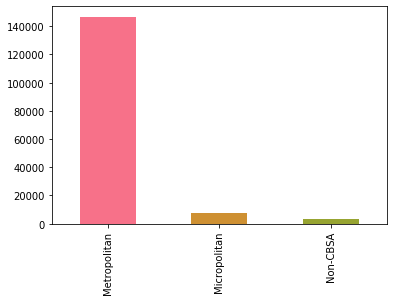

In [16]:
print(df['metro'].value_counts())
print(df['metro'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Household Type
Household type is measured by character variable “H6”. H6 equals “1” for households with an elderly head or spouse, and no children. H6 equals “2” for non-elderly households where the head or spouse has disabilities, and there are no children. H6 equals “3” for other households with no children. H6 equals “4” for households with an elderly head or spouse, with children. H6 equals “5” for non-elderly households where the head or spouse has disabilities, with children present. H6 equals “6” for other households with children. Elderly is defined as age 62 and above.

After filtering the dataset, the household types break down: 

1    69661
6    39142
2    26892
3    16341
5     4987
4     1000
Name: h6, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


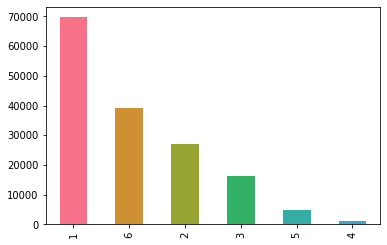

In [17]:
print(df['h6'].value_counts())
print(df['h6'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Household Members
Household member counts are measured by numeric variable “mbrs”, taking values of 1-7. Household members is top-coded at 7, thus 7 represents 7 or more householders. Missing or suppressed values are blank.

After filtering the dataset, the household members groups break down: 

1    93462
2    29141
3    17377
4    10343
5     4684
6     1696
7     1320
Name: mbrs, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


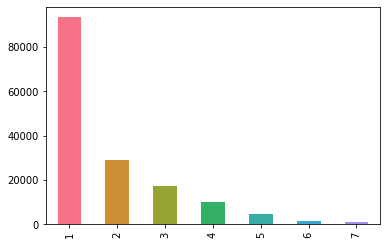

In [18]:
print(df['mbrs'].value_counts())
print(df['mbrs'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Bedroom Counts 
Bedroom counts are measured by numeric variable “bdrms”, taking values of 0-4. Bedroom counts are top-coded at 4, thus 4 represents 4 or more bedrooms. Missing or suppressed values are blank.

After filtering the dataset, the bedroom groups break down: 

1    71491
2    46622
3    26364
0     8730
4     4816
Name: bdrms, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


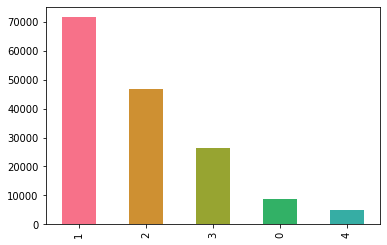

In [19]:
print(df['bdrms'].value_counts())
print(df['bdrms'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Race Categories
Race and ethnicity of the household head is measured by character variable “race_eth”. Race and ethnicity are reported in four categories. For Hispanics of any race, race_eth equals “Hispanic”. For non-Hispanic whites, race_eth equals “White”. For non-Hispanic blacks, race_eth equals “Black”. For other non-Hispanics, race_eth equals “Other”. Missing or suppressed values are blank.

After filtering the dataset, the race demographic break down: 

Race Counts
Black       66597
White       48969
Hispanic    33257
Other        9200
Name: race_eth, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Race Percentage
Black: 42.14%
White: 30.99%
Hispanic: 21.05%
Other: 5.82%


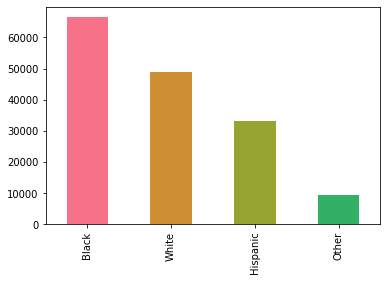

In [20]:
print("Race Counts")
print(df['race_eth'].value_counts())
print(df['race_eth'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

print("\n\nRace Percentage")
print("Black: %.2f%%" %            (66597 / 158023 * 100))
print("White: %.2f%%" %            (48969 / 158023 * 100))
print("Hispanic: %.2f%%" %         (33257 / 158023 * 100))
print("Other: %.2f%%" %            (9200 / 158023 * 100))

#### Sex
Sex of household head is measured by character variable “sex”. Males are coded as “M”, and females are coded as “F”. Missing or suppressed values are blank.

After filtering the dataset, the sex demographic break down:

Sex Counts
F    119838
M     38185
Name: sex, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


Sex Percentage
Men: 24.16%
Women: 75.84%


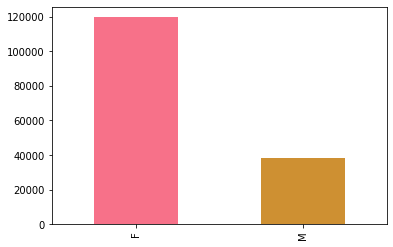

In [21]:
print('Sex Counts')
print(df['sex'].value_counts())
print(df['sex'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

print('\n\nSex Percentage')
print("Men: %.2f%%" %   (38185 / 158023 * 100))
print("Women: %.2f%%" % (119838 / 158023 * 100))

#### Annual Household Income Categories
Annual household income is measured by character variable “inc5000”. The 2009 PUMS reports income in 13 categories. The first 12 categories report income in 5,000 increments: 0-5,000, 5001-10,000, up to 55,001-60,000. The thirteenth category is for households with income between 60,001 and 90,000. Income is top-coded at 90,000. Starting in 2010, the PUMS reports income in 12 categories. The first eight categories report income in 2,500 increments: 0-2,500, 2,501-5,000, 17,501-20,000. The next two categories report income in 5,000 increments: 20,001-25,000, and 25,001-30,000. The 11th category is for households with income between 30,001 and 40,000. The 12th category is for households with income between 40,001 and 90,000. Income is top-coded at 90,000.

After filtering the dataset, the annual household income break down:

$7,501-$10,000     35726
$10,001-$12,500    33501
$12,501-$15,000    15599
$20,001-$25,000    12368
$15,001-$17,500    11074
$17,501-$20,000    10201
$30,001-$40,000     8280
$40,001-$90,000     7547
$25,001-$30,000     7183
$2,501-$5,000       6082
$5,001-$7,500       5652
$0-$2,500           4810
Name: inc5000, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


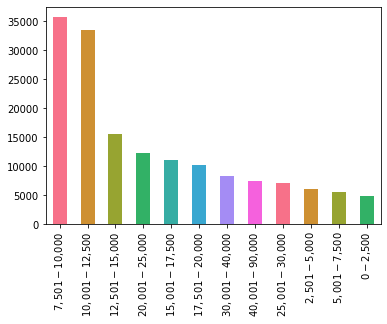

In [22]:
print(df['inc5000'].value_counts())
print(df['inc5000'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Adjusted Household Income Categories
Eligibility for HUD rental assistance programs is based on adjusted household income. Adjusted income is calculated by subtracting off certain expenses from household income. Details of the calculation for PIH programs are reported on HUD form 500585, and on HUD form 500596 for Office of Housing programs. Annual adjusted household income is reported in the same categories as annual household income, and is also top-coded at 90,000. Adjusted household annual income is measured by character variable “ainc5000”. Adjusted household annual income is reported in the same categories as annual household income, and is also top-coded at 90,000.

After filtering the dataset, the adjusted household income break down:

$7,501-$10,000     40441
$10,001-$12,500    31450
$12,501-$15,000    15486
$15,001-$17,500    10769
$20,001-$25,000    10758
$17,501-$20,000     8946
$30,001-$40,000     7472
$5,001-$7,500       7036
$40,001-$90,000     7033
$25,001-$30,000     6345
$2,501-$5,000       6192
$0-$2,500           6095
Name: ainc5000, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


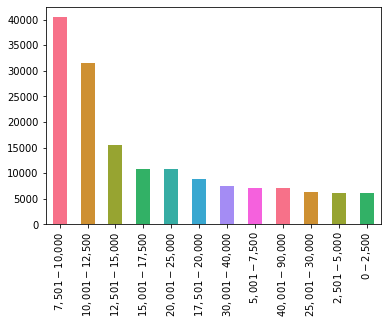

In [23]:
print(df['ainc5000'].value_counts())
print(df['ainc5000'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Rent Burden Categories
Rent burden is defined as gross rent (including utility costs) divided by monthly adjusted household income. Rent burden is undefined for households with 0 adjusted income. Rent burden is measured by character variable “brdn”. Rent burden is reported in four categories: 0%-31%, 32%-39%, 40%-49%, and 50% and above.

After filtering the dataset, the rent burden break down:

0%-31%           138936
32%-39%            9079
50% and above      6727
40%-49%            3281
Name: brdn, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


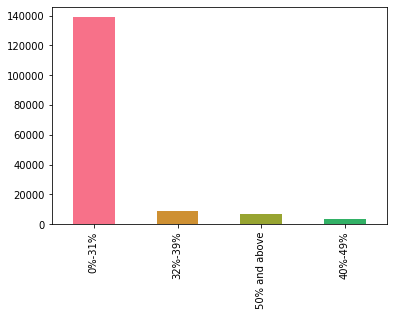

In [24]:
print(df['brdn'].value_counts())
print(df['brdn'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Target Variable: sec_8
The target variable for project based section 8 tenants, equals 1. For section 202 tenants and section 811 tenants, this variable equals 0. The target is highly imbalanced with more of this dataset being a section 8 tenant. To address this I'll use a SMOTE oversampling technique. 

0    111210
1     46813
Name: sec_8, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


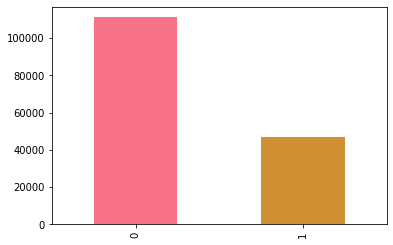

In [25]:
print(df['sec_8'].value_counts())
print(df['sec_8'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

## 4.1 Exploratory Data Analysis Insights and Explanation 
- The target variable is highly imbalanced with majority of the dataset being classifies as living within section 8 housing. 
- Majority of the tenants in this dataset live in Metropolitan areas.
- The rent burden, AKA the percentage of a tenants adjusted income goes towards rent, accounts for most tenants 0-31% of their adjusted income. This is typically a good range for tenants because the suggested rent percentage one should spend is up to 25% of ones income. However, when one lives below the poverty line, the income spent outside of rent may not be enough to provide typical living expenses and necessities. 
- Majority of tenants live off of 7,501-10,000 and 10,001-12,500 annual income. Unfortunately, these household income categories are well below the poverty line, which is why in most cases tenants are living in section 8 housing.  
- Majority of this dataset includes a female head of households. With a large portion of this dataset being caucasian or african american. 
- Majority of tenants are elderly and live alone in a single room household. 

# 5. Data Preparation 

#### Missing Values 
Missing values were handled outside of this notebook in Excel. Therefore, there are no missing values that need ot be handled. Below are the steps taken outside of this Jupyter Notebook.

- If the state had a value of Z Missing, those records were removed.

- The ur, metro, sex, and brdn features had many blank values, many of which matched with the 'Z Missing' values in the state feature. Those records instead of being imputed, were removed due to the consideratin of keeping the data as similiar as possible to the original data without modification. There are plenty of records within this dataset in which the records with data quality issues would not affect the results of the model. # Data Preparation

<Figure size 1296x360 with 0 Axes>

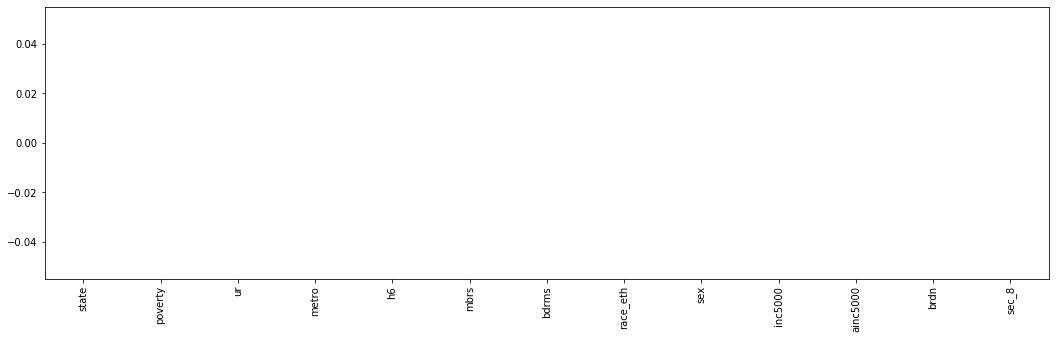

In [26]:
plt.figure(figsize = (18,5))
df.isnull().sum().plot(kind='bar',color=sns.color_palette("husl", 8))

#### Map values in place
Mapping values in place is used instead of one hot encoding to perform the fairness assessment using IBM's AIF360 package. 

#### Sex
- 0: Female
- 1: Male

#### Race
- 0: Black
- 1: Hispanic
- 2: Other
- 3: White

#### Poverty
- 0: 0%-9%
- 1: 10%-19%
- 2: 20%-29%
- 3: 30%-39%
- 4: 40% and above

#### Urban or Rural
- 0: R
- 1: U

#### Metropolitan
- 0: Metropolitan
- 1: Micropolitan
- 2: Non-CBSA

#### Household Income 
- 0: 0-2,500
- 1: 10,001-12,500
- 2: 12,501-15,000
- 3: 15,001-17,500
- 4: 17,501-20,000
- 5: 2,501-5,000
- 6: 20,001-25,000
- 7: 25,001-30,000
- 8: 30,001-40,000
- 9: 40,001-90,000
- 10: 5,001-7,500
- 11: 7,501-10,000

#### Adjusted Household Income 
- 0: 0-2,500
- 1: 10,001-12,500
- 2: 12,501-15,000
- 3: 15,001-17,500
- 4: 17,501-20,000
- 5: 2,501-5,000
- 6: 20,001-25,000
- 7: 25,001-30,000
- 8: 30,001-40,000
- 9: 40,001-90,000
- 10: 5,001-7,500
- 11: 7,501-10,000

#### Rent Burden
- 0: 0%-31%
- 1: 32%-39% 
- 2: 40%-49%
- 3: 50% and above

#### States
- 0: Alabama
- 1: Alaska
- 2: Arizona
- 3: Arkansas
- 4: California
- 5: Colorado
- 6: Connecticut
- 7: Delaware
- 8: District of Columbia
- 9: Florida
- 10: Georgia
- 11: Hawaii
- 12: Idaho
- 13: Illinois
- 14: Indiana
- 15: Iowa
- 16: Kansas
- 17: Kentucky
- 18: Louisiana
- 19: Maine
- 20: Maryland
- 21: Massachusetts
- 22: Michigan
- 23: Minnesota
- 24: Mississippi
- 25: Missouri
- 26: Montana
- 27: Nebraska
- 28: Nevada
- 29: New Hampshire
- 30: New Jersey
- 31: New Mexico
- 32: New York
- 33: North Carolina
- 34: North Dakota
- 35: Ohio
- 36: Oklahoma
- 37: Oregon
- 38: Pennsylvania
- 39: Puerto Rico
- 40: Rhode Island
- 41: South Carolina
- 42: South Dakota
- 43: Tennessee
- 44: Texas
- 45: Utah
- 46: Vermont
- 47: Virginia
- 48: Washington
- 49: West Virginia
- 50: Wisconsin
- 51: Wyoming

In [27]:
df['state'] = df.state.astype("category").cat.codes
df['poverty'] = df.poverty.astype("category").cat.codes
df['ur'] = df.ur.astype("category").cat.codes
df['metro'] = df.metro.astype("category").cat.codes
df['race_eth'] = df.race_eth.astype("category").cat.codes
df['sex'] = df.sex.astype("category").cat.codes
df['inc5000'] = df.inc5000.astype("category").cat.codes
df['ainc5000'] = df.ainc5000.astype("category").cat.codes
df['brdn'] = df.brdn.astype("category").cat.codes
df.head()

,state,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,sec_8
0,0,0,1,0,1,1,1,3,0,2,2,0,0
1,0,0,1,0,1,1,1,3,0,6,3,0,0
2,0,0,1,0,1,1,1,3,0,11,11,0,0
3,0,1,1,0,1,1,1,0,0,11,11,0,0
4,0,1,1,0,1,1,1,0,1,11,11,0,0


In [28]:
df.shape
df.describe()

(158023, 13)

,state,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,sec_8
count,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000
mean,24.213494,2.022933,0.973554,0.093493,2.760706,1.823045,1.664891,1.256551,0.241642,5.551679,5.750555,0.226689,0.296242
std,13.945408,1.300437,0.160457,0.359130,2.058665,1.256679,0.921867,1.285843,0.428080,3.951065,4.060678,0.687203,0.456600
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,30.000000,2.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,5.000000,6.000000,0.000000,0.000000
75%,33.000000,3.000000,1.000000,0.000000,5.000000,2.000000,2.000000,3.000000,0.000000,10.000000,11.000000,0.000000,1.000000
max,51.000000,4.000000,1.000000,2.000000,6.000000,7.000000,4.000000,3.000000,1.000000,11.000000,11.000000,3.000000,1.000000


#### Correlation Plot with Mapped Values 
Now that the categorical features are ampped to numerical values the correlation plot may show us relationships between protected attributes or variables masked as proxies for those protected attribtues. There is multicollinearity between several of the variables. Multicollinearity is a common problem when estimating linear or generalized linear models, including logistic regression, which is one of the models I will use to classify section 8 tenants. Multicollinearity occurs when there are high correlations among predictor variables, leading to unreliable and unstable estimates of regression coefficients. It is typically not a good thing to have in a model. 

#### VIF
The variance inflation factor estimates how much the variance of a coefficient is “inflated” because of linear dependence with other predictors. Thus, a VIF of 1.8 tells us that the variance (the square of the standard error) of a particular coefficient is 80% larger than it would be if that predictor was completely uncorrelated with all the other predictors.

The VIF has a lower bound of 1 but no upper bound. Authorities differ on how high the VIF has to be to constitute a problem. Personally, I tend to get concerned when a VIF is greater than 2.50, which corresponds to an R2 of .60 with the other variables.

<Figure size 1080x576 with 0 Axes>

,Features,VIF
0,state,3.943528
1,poverty,3.773094
2,ur,11.593623
3,metro,1.183090
4,h6,7.521196
5,mbrs,10.251205
6,bdrms,10.404510
7,race_eth,2.316325
8,sex,1.460270
9,inc5000,9.935909


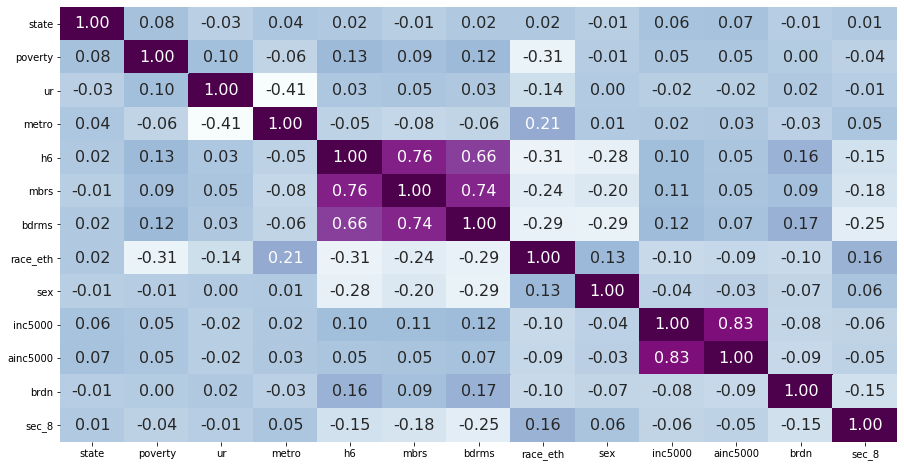

In [29]:
# Plot correlation matrix
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),
           cmap='BuPu',
           annot=True,
           fmt=".2f",
           annot_kws={'size':16},
           cbar=False)

# Calculate VIF values for each feature
def calc_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df.iloc[:,:-1]
calc_vif(X)

In [30]:
df.shape
df.head()

(158023, 13)

,state,poverty,ur,metro,h6,mbrs,bdrms,race_eth,sex,inc5000,ainc5000,brdn,sec_8
0,0,0,1,0,1,1,1,3,0,2,2,0,0
1,0,0,1,0,1,1,1,3,0,6,3,0,0
2,0,0,1,0,1,1,1,3,0,11,11,0,0
3,0,1,1,0,1,1,1,0,0,11,11,0,0
4,0,1,1,0,1,1,1,0,1,11,11,0,0


#### Final Model Feature Selection 
Due to the multicollinearity of the predictors, the bedrooms and household income features will be left out of the final model. 

In [31]:
df = df.drop(['bdrms','inc5000'],axis=1)

# 6. Split the Dataset into Training and Testing Sets
In this section I will define the target variable and features, apply a SMOTE data oversampling technique to minimize the effect of an imbalanced dataset, and split data into 70/30 segments.

In [32]:
# Define target and features
target = df['sec_8']
features = df.drop(['sec_8'], axis=1)
print(features)

        state  poverty  ur  metro  h6  mbrs  race_eth  sex  ainc5000  brdn
0           0        0   1      0   1     1         3    0         2     0
1           0        0   1      0   1     1         3    0         3     0
2           0        0   1      0   1     1         3    0        11     0
3           0        1   1      0   1     1         0    0        11     0
4           0        1   1      0   1     1         0    1        11     0
...       ...      ...  ..    ...  ..   ...       ...  ...       ...   ...
107994     39        4   1      0   6     5         1    0         0     3
107995     39        4   1      0   6     5         1    0         0     0
107996     39        4   1      0   6     5         1    0         0     0
107997     39        4   1      0   6     5         1    0         5     0
107998     39        4   1      0   6     6         1    0         5     0

[158023 rows x 10 columns]


In [33]:
# Split into train/test while maintaining stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (110616, 10)
Number of data points in test data: (47407, 10)


#### SMOTE Data Sampling 
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

In [34]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 7. Create and Compare ML Classification Models

### XGBoost Model Grid Search
Create a XGBoost model with the best performing parameters from a grid search to classify tenants who live in section 8 housing. 

In [35]:
# Create a XGBoost classifier 
xgb_clf=xgb.XGBClassifier()

# Define param grid to use random reach on 
param_grid = {
    'silent': [False],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100, 200, 400, 500, 1000],
    'objective': ['binary:logistic']
}

fit_params = {'eval_metric': 'logloss',
             'early_stopping_rounds': 10,
             'eval_set':[(X_test, y_test)]}

rs_clf = RandomizedSearchCV(xgb_clf, param_grid, n_iter = 20,
                           n_jobs=-1, verbose=2, cv=3,
                           scoring='neg_log_loss', refit=False, random_state=42)

print("Randomized Search")
rs_clf.fit(X_train, y_train, **fit_params)
print('Randomized Search Complete')

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best Score: {}".format(best_score))
print("Best Params: ")

for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

### XGBoost Model
Apply the optimal hyperparameters to train the XGBoost classifier to classify tenants of section 8 housing. Predict on the test set. 

In [36]:
# Fit final model with best params
x_clf = XGBClassifier(colsample_bylevel= 1.0, colsample_bytree= 1.0, gamma= 0.5, learning_rate= 0.1, max_depth= 6, 
                      min_child_weight= 7.0, n_estimators= 1000, objective= 'binary:logistic', reg_alpha= 1.0, 
                      reg_lambda= 0.1, silent= False, subsample= 0.6, eval_metrics='logloss',random_state=42)

x_clf.fit(X_train,y_train)

# Predict using test set
x_pred = x_clf.predict(X_test)
x_prob_pred = x_clf.predict_proba(X_test)[:,1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_metrics", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, eval_metrics='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=7.0, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=1.0,
              reg_lambda=0.1, scale_pos_weight=1, silent=False, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

### SMOTE XGBoost Model
Apply the optimal hyperparameters to train the XGBoost classifier to classify tenants of section 8 housing. Predict on the test set. 

In [37]:
# Fit final model with best params
res_x_clf = XGBClassifier(colsample_bylevel= 1.0, colsample_bytree= 1.0, gamma= 0.5, learning_rate= 0.1, max_depth= 6, 
                      min_child_weight= 7.0, n_estimators= 1000, objective= 'binary:logistic', reg_alpha= 1.0, 
                      reg_lambda= 0.1, silent= False, subsample= 0.6, eval_metrics='logloss',random_state=42)

res_x_clf.fit(X_res,y_res)

# Predict using test set
res_x_pred = res_x_clf.predict(X_test)
res_x_prob_pred = res_x_clf.predict_proba(X_test)[:,1]

[17:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_metrics", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, eval_metrics='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=7.0, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=1.0,
              reg_lambda=0.1, scale_pos_weight=1, silent=False, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Random Forest Model
Create a Random Forest to classify tenants who have a section 8 housing voucher.

In [38]:
# Fit final model with best params
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)

# Predict using test set
rf_pred = rf_clf.predict(X_test)
rf_prob_pred = rf_clf.predict_proba(X_test)[:,1]

RandomForestClassifier(random_state=42)

### SMOTE Random Forest Model
Create a Random Forest to classify tenants who have a section 8 housing voucher.

In [39]:
# Fit final model with best params
res_rf_clf = RandomForestClassifier(random_state=42)
res_rf_clf.fit(X_res,y_res)

# Predict using test set
res_rf_pred = res_rf_clf.predict(X_test)
res_rf_prob_pred = res_rf_clf.predict_proba(X_test)[:,1]

RandomForestClassifier(random_state=42)

### Logistic Regression Model
Create a Logistic Regression to classify tenants who have a section 8 housing voucher.

In [40]:
# Fit final model with best params
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train,y_train)

# Predict using test set
lr_pred = lr_clf.predict(X_test)
lr_prob_pred = lr_clf.predict_proba(X_test)[:,1]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=42)

### SMOTE Logistic Regression Model
Create a Logistic Regression to classify tenants who have a section 8 housing voucher.

In [41]:
# Fit final model with best params
res_lr_clf = LogisticRegression(random_state=42)
res_lr_clf.fit(X_res,y_res)

# Predict using test set
res_lr_pred = res_lr_clf.predict(X_test)
res_lr_prob_pred = res_lr_clf.predict_proba(X_test)[:,1]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=42)

# 8. Model Evaluation Metrics

### Accuracy
Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples.
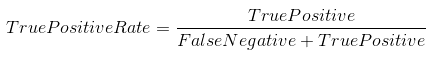 

### Sensitivity
True Positive Rate is defined as TP/ (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points.
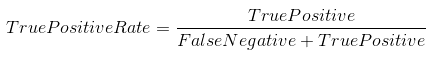

### Specificity 
True Negative Rate is defined as TN / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are correctly considered as negative, with respect to all negative data points.
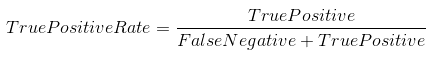

### Precision 
It is the number of correct positive results divided by the number of positive results predicted by the classifier.
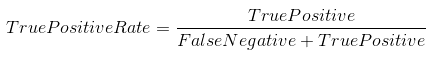

### F1 Score
F1 Score is the Harmonic Mean between precision and recall. F1 Score tries to find the balance between precision and recall. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances). High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. 
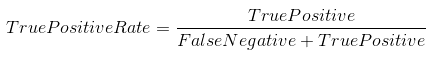


,XGBoost,Random Forest,Logistic Regression,SMOTE XGBoost,SMOTE Random Forest,SMOTE Logistic Regression
Accuracy,0.7413,0.7174,0.7061,0.6810,0.6657,0.5869
Sensitivity,0.3711,0.3944,0.0054,0.7142,0.6342,0.7055
Specificity,0.8949,0.8514,0.9968,0.6672,0.6788,0.5377
Precision Positive,0.5943,0.5240,0.4144,0.4710,0.4503,0.3877
Precision Negative,0.7742,0.7721,0.7072,0.8491,0.8172,0.8148
F1 Score Positive,0.4569,0.4501,0.0107,0.5677,0.5267,0.5004
F1 Score Negative,0.8302,0.8098,0.8274,0.7472,0.7416,0.6478


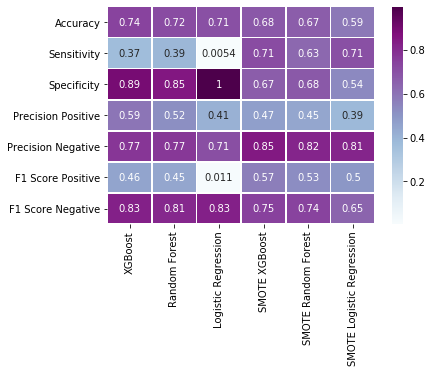

In [42]:
# Create classification model eval method
def model_eval(y, prediction): 
    """
    Method to calculate model evaluation metrics to measure the effectiveness of the model. 
    
    :param y (numpy array): Train or test target values for ML model
    :param prediction (numpy array): Predictions from the ML model
    """
    accuracy = round(metrics.accuracy_score(y, prediction), 4)
    recall_sensitivity = round(metrics.recall_score(y, prediction), 4)
    recall_specificity = round(metrics.recall_score(y, prediction, pos_label=0), 4)
    precision_positive = round(metrics.precision_score(y, prediction), 4)
    precision_negative = round(metrics.precision_score(y, prediction, pos_label=0), 4)
    positive_f1_score = round(metrics.f1_score(y, prediction), 4)
    negative_f1_score = round(metrics.f1_score(y, prediction, pos_label=0), 4)
    
    model_eval_metrics = {'Accuracy': accuracy,
              'Sensitivity': recall_sensitivity,
              'Specificity': recall_specificity,
              'Precision Positive': precision_positive,
              'Precision Negative': precision_negative,
              'F1 Score Positive': positive_f1_score,
              'F1 Score Negative': negative_f1_score}
    
    return(model_eval_metrics)

# Call model evaluation metrics
x_results = model_eval(y_test, x_pred)
rf_results = model_eval(y_test, rf_pred)
lr_results = model_eval(y_test, lr_pred)
smote_x_results = model_eval(y_test, res_x_pred)
smote_rf_results = model_eval(y_test, res_rf_pred)
smote_lr_results = model_eval(y_test, res_lr_pred)

# Visualize model evaluation metrics in a heatmap 
xgbmodel = x_results
rfmodel = rf_results
lrmodel = lr_results
smote_xgbmodel = smote_x_results
smote_rfmodel = smote_rf_results
smote_lrmodel = smote_lr_results

viz = pd.DataFrame.from_dict(xgbmodel, orient='index', columns=['XGBoost'])
viz['Random Forest'] = pd.DataFrame.from_dict(rfmodel, orient='index', columns=['Random Forest'])
viz['Logistic Regression'] = pd.DataFrame.from_dict(lrmodel, orient='index', columns=['Logistic Regression'])
viz['SMOTE XGBoost'] = pd.DataFrame.from_dict(smote_xgbmodel, orient='index', columns=['SMOTE XGBoost'])
viz['SMOTE Random Forest'] = pd.DataFrame.from_dict(smote_rfmodel, orient='index', columns=['SMOTE Random Forest'])
viz['SMOTE Logistic Regression'] = pd.DataFrame.from_dict(smote_lrmodel, orient='index', columns=['SMOTE Logistic Regression'])

viz.head(10)
ax = sns.heatmap(viz,
                cmap = 'BuPu',
                linewidths = .5,
                annot = True)

## 8.1 Model Evaluation Explanation
#### SMOTE Oversampling vs No Oversampling
Class imbalance is a common issue and if not handled can have a telling impact on the model performance and is especially critical for the minority class. As we can see from the results, the models that used a SMOTE oversampling technique had better accuracy for the minority class. However, overall the SMOTE models were less performant in all other model evaluation scores. For the purpose of this project, I will be selecting a model that uses the SMOTE oversampling technique because I'm interested in explaining the minority class. 

#### Logistic Regression vs Random Forest vs XGBoost
The logistic regression model performs less accurately and efficiently than the XGBoost and random forest models. The XGBoost and random forest models are highly complex algorithms that could potentially be complicated to understand or explain how the alogrithms make decisions. The logistic regression is less computationally heavy and can be explained better than the more complicated algorithms like xgboost and random forest. For the purpose of this project, I will be selecting the most performant model because I'm interested in explaining the accuracy overall. 

#### Final Model Selection
For the remaining analysis I will be using the <b>SMOTE XGBoost model</b>. It is the most performant of the models that used an oversampling technique. There are ultimately more factors when selecting a final model and I'll be exploring the fairness of the XGBoost model.  

# 9. Fairness Evaluation and Bias Detection
Fairness Detection Documentation: https://aif360.readthedocs.io/en/latest/modules/sklearn.html#module-aif360.sklearn.metrics 

### Individual vs. Group Fairness, or Both
Group fairness, in its broadest sense, partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across groups.  Individual fairness, in its broadest sense, seeks for similar individuals to be treated similarly.  If the application is concerned with individual fairness, then the metrics in the SampleDistortionMetric class should be used.  If the application is concerned with group fairness, then the metrics in the DatasetMetric class (and in its children classes such as the BinaryLabelDatasetMetric class) as well as the ClassificationMetric class (except the ones noted in the next sentence) should be used.  If the application is concerned with both individual and group fairness, and requires the use of a single metric, then the generalized entropy index and its specializations to Theil index and coefficient of variation in the ClassificationMetric class should be used.  Of course, multiple metrics, including ones from both individual and group fairness can be examined simultaneously.

### Convert Test Data into a BinaryLabelDataset to Calculate ClassificationMetric Methods
Binary label datasets are the base class for all structured datasets with binary labels in the AIF360 library. Data must be converted to the BLD format in order to utilize the packages features and metrics. 

In [43]:
# Construct the test dataframe 
test_df = pd.DataFrame(X_test)
test_df['sec_8'] = y_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['sec_8'],
                            protected_attribute_names=['race_eth','sex'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'race_eth':0}] # African American 
privileged_groups = [{'race_eth':3}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
clf_metric = ClassificationMetric(bld_df,
                              bld_df_pred,
                              unprivileged_groups,
                              privileged_groups)

### HUD Fairness Assessment
In this section, I'll be conducting a fairness assessment. The goal is to detect bias and will be focussing on protected classes like race, sex, and other factors that could be proxies to protected attributes. From the EDA conducted on the HUD dataset, we know that majority of tenants live well below the poverty line and affect female head of households disproportionately.  

The first step in creating trustworthy AI is bias identification. Once algorithmic bias has been detected, data scientists can then take steps towards mitigating bias. With the help of open-source libraries, there are fairness measures available for evaluating models for unintentional bias. Below is the bias detection function that will be used to conduct the fairness assessment. It will also be used in the bias mitigation step to identify changes in bias. 

In [44]:
def fairness_bias_detection(clf_metric):    
    metrics = {"Accuracy":clf_metric.accuracy(),
               "Disparate Impact":clf_metric.disparate_impact(),
               "Statistical Parity Difference":clf_metric.statistical_parity_difference(),
               "Equal Opportunity Difference":clf_metric.equal_opportunity_difference(),
               "Average Odds Difference":clf_metric.average_odds_difference(),
               "Theil Index":clf_metric.theil_index(),
               "False Positive Rate":clf_metric.false_positive_rate(),
               "False Negative Rate":clf_metric.false_negative_rate(),
               "False Omission Rate":clf_metric.false_omission_rate(),
               "False Discovery Rate":clf_metric.false_discovery_rate(),
               "Error Rate":clf_metric.error_rate(),
               "Differential Fairness Bias Amplification":clf_metric.differential_fairness_bias_amplification()}
    
    return(metrics)

In [45]:
# Call fairness assessment metrics 
fair_assessment = fairness_bias_detection(clf_metric)

### Visualize Fairness Assessment: Bias Detection Metrics 

,SMOTE XGBoost Fairness Assessment
Accuracy,0.680996
Disparate Impact,0.510025
Statistical Parity Difference,-0.297962
Equal Opportunity Difference,-0.238275
Average Odds Difference,-0.245003
Theil Index,0.142211
False Positive Rate,0.332786
False Negative Rate,0.285786
False Omission Rate,0.150904
False Discovery Rate,0.528962


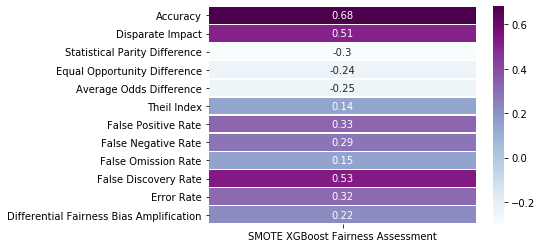

In [46]:
fair_viz = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])
fair_viz = fair_viz.iloc[0:12]
fair_viz['SMOTE XGBoost Fairness Assessment'] = fair_viz['SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## Deep Dive into the Fairness Assessment: Group Fairness Metrics

### Disparate Impact 

Legal theory that states a practice is considered illegal discrimination if it has a “disproportionately adverse” effect on members of a protected group. “disproportionately adverse” is usually defined using the 80% Rule, otherwise known as the four fifths rule.

Disparate impact and the four fifths rule are directly related. Disparate impact is used in legal proceedings and can be typically found in law affecting employment policies. It enables challenges to policies that place a disproportionate burden on members of a protected class. It’s a way to prove employment discrimination and can be used to prove discrimination in other scenarios. The four fifths rule, also known as the 80% rule, is a guideline used to prove adverse effect on marginalized groups. The two bias detection techniques are typically used together to prove discrimination against protected groups.

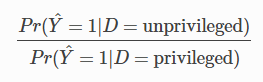

In [47]:
clf_metric.disparate_impact()

0.5100245204169314

### Four Fifths Rule
The Four-Fifths rule states that if the selection rate for a certain group is less than 80 percent of that of the group with the highest selection rate, there is adverse impact on that group. 

In [48]:
# create a dataframe for bias detection   
bias_detect_df = test_df
bias_detect_df['pred'] = res_x_pred

#### Race
- 0: Black
- 1: Hispanic
- 2: Other
- 3: White

The ratio of section 8 classifications made by the model for tenants of differing races does *not* pass the four fifths rule. There is a slight overt disparate race impact in the model that disproportionatly affects tenants who are categorized as Hispanic, Caucasion, or African American. 

<BarContainer object of 4 artists>

Text(0, 0.5, 'Relative Positive Classification Rates')

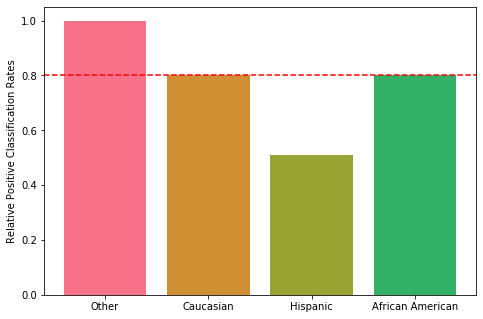

In [49]:
# define race sub categories
african_american = bias_detect_df[bias_detect_df['race_eth']==0]
hispanic = bias_detect_df[bias_detect_df['race_eth']==1]
other = bias_detect_df[bias_detect_df['race_eth']==2]
caucasian = bias_detect_df[bias_detect_df['race_eth']==3]

# calculate race sub category rates
rate_african_american = sum(african_american['pred'])/len(african_american)
rate_caucasian = sum(caucasian['pred'])/len(caucasian)
rate_hispanic = sum(hispanic['pred'])/len(hispanic)
rate_other = sum(other['pred'])/len(other)

# print(rate_african_american, rate_caucasian, rate_hispanic, rate_other)

# calculate race sub category ratio 
ratio_african_american = rate_caucasian/rate_other
ratio_caucasian = rate_caucasian/rate_other
ratio_hispanic = rate_hispanic/rate_other
# ratio_other = rate_other/rate_african_american

# plot four fifths visualization for race sub categories
fig = plt.figure()
race_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Other', 'Caucasian','Hispanic','African American']
rates = [1, ratio_caucasian, ratio_hispanic, ratio_african_american]
race_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
race_four_fifth.set_ylabel('Relative Positive Classification Rates')
race_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Sex
- 0: Female
- 1: Male

The ratio of section 8 classifications made by the model for men and women passess the four fifths rule. While one interpretation of this is that there may not be an overt disparate gender impact in the model, it's still important to document why this may be the case. 

<BarContainer object of 2 artists>

Text(0, 0.5, 'Relative Positive Classification Rates')

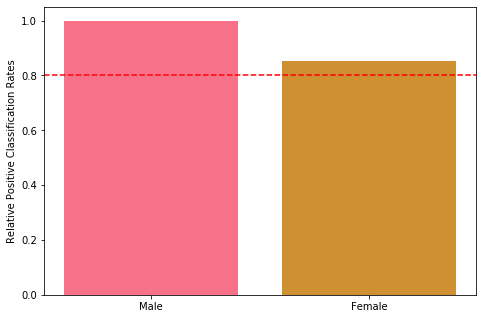

In [50]:
# define sex sub categories
male = bias_detect_df[bias_detect_df['sex']==1]
female = bias_detect_df[bias_detect_df['sex']==0]

# calculate sex sub category rates
rate_male = sum(male['pred'])/len(male)
rate_female = sum(female['pred'])/len(female)
 
# print(rate_female,rate_male)    

# calculate the sex sub category ratio
ratio = rate_female/rate_male

# plot four fifths visualization for sex sub categories
fig = plt.figure()
sex_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Male', 'Female']
rates = [1, ratio]
sex_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
sex_four_fifth.set_ylabel('Relative Positive Classification Rates')
sex_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Poverty 
- 0: 0%-9%
- 1: 10%-19%
- 2: 20%-29%
- 3: 30%-39%
- 4: 40% and above

The ratio of section 8 classifications made by the model for tenants of differing poverty levels does *not* pass the four fifths rule. There is an overt disparate poverty impact in the model that disproportionatly affects tenants who have very high or high poverty levels.

<BarContainer object of 5 artists>

Text(0, 0.5, 'Relative Positive Classification Rates')

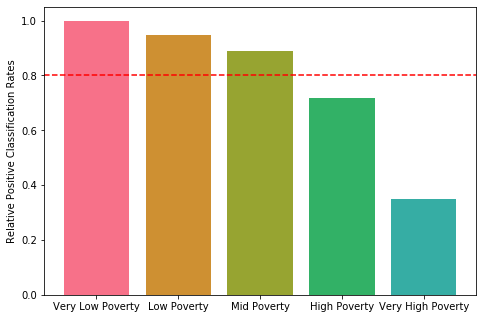

In [51]:
# define poverty sub categories
very_low = bias_detect_df[bias_detect_df['poverty']==0]
low = bias_detect_df[bias_detect_df['poverty']==1]
middle = bias_detect_df[bias_detect_df['poverty']==2]
high = bias_detect_df[bias_detect_df['poverty']==3]
very_high = bias_detect_df[bias_detect_df['poverty']==4]

# calculate poverty sub category rates
rate_very_low = sum(very_low['pred'])/len(very_low)
rate_low = sum(low['pred'])/len(low)
rate_middle = sum(middle['pred'])/len(middle)
rate_high = sum(high['pred'])/len(high)
rate_very_high = sum(very_high['pred'])/len(very_high)

# print(rate_very_low,rate_low,rate_middle,rate_high,rate_very_high)    

# calculate poverty sub category ratio 
# ratio_very_low = rate_very_low/rate_very_low
ratio_low = rate_low/rate_very_low
ratio_middle = rate_middle/rate_very_low
ratio_high = rate_high/rate_very_low
ratio_very_high = rate_high/rate_very_low


# plot four fifths visualization for poverty sub categories
fig = plt.figure()
age_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Very Low Poverty', 'Low Poverty', 'Mid Poverty', 'High Poverty', 'Very High Poverty']
rates = [1, ratio_low, ratio_middle, ratio_high, rate_very_high]
age_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
age_four_fifth.set_ylabel('Relative Positive Classification Rates')
age_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Urban or Rural
- 0: R
- 1: U

The ratio of section 8 classifications made by the model for tenants of rural and urban areas does pass the four fifths rule. There is not an overt disparate impact in the model that disproportionatly affects tenants living in urban or rural areas. 

<BarContainer object of 2 artists>

Text(0, 0.5, 'Relative Positive Classification Rates')

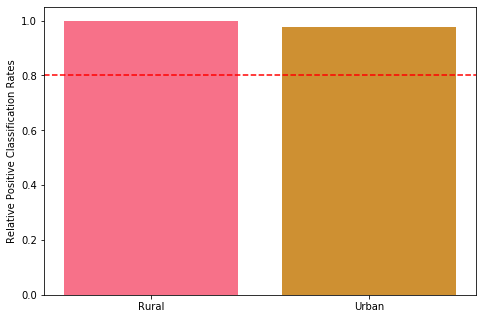

In [52]:
# define ur sub categories
urban = bias_detect_df[bias_detect_df['ur']==1]
rural = bias_detect_df[bias_detect_df['ur']==0]

# calculate ur sub category rates
rate_urban = sum(urban['pred'])/len(urban)
rate_rural = sum(rural['pred'])/len(rural)

# print(rate_urban,rate_rural)    

# calculate ur sub category ratio 
ratio_urban = rate_urban/rate_rural

# plot four fifths visualization for ur sub categories
fig = plt.figure()
age_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Rural', 'Urban']
rates = [1, ratio_urban]
age_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
age_four_fifth.set_ylabel('Relative Positive Classification Rates')
age_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Adjusted Household Income 
- 0: 0-2,500
- 1: 10,001-12,500
- 2: 12,501-15,000
- 3: 15,001-17,500
- 4: 17,501-20,000
- 5: 2,501-5,000
- 6: 20,001-25,000
- 7: 25,001-30,000
- 8: 30,001-40,000
- 9: 40,001-90,000
- 10: 5,001-7,500
- 11: 7,501-10,000

The ratio of section 8 classifications made by the model for tenants of differing adjusted household incomes does *not* pass the four fifths rule. There is an overt income disparate impact in the model that disproportionatly affects households that make 5,000-10,000 & 12,500-17,500 & 30,000-90,000. annually. 

<BarContainer object of 11 artists>

Text(0, 0.5, 'Relative Positive Classification Rates')

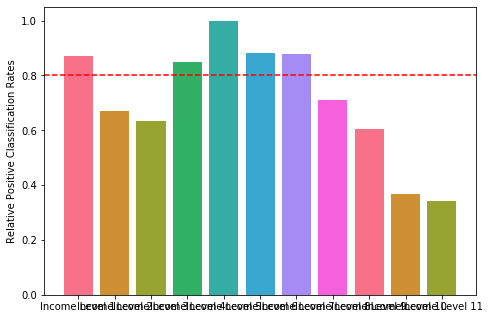

In [53]:
# define adjusted household income sub categories
income1 = bias_detect_df[bias_detect_df['ainc5000']==0]
income2 = bias_detect_df[bias_detect_df['ainc5000']==5]
income3 = bias_detect_df[bias_detect_df['ainc5000']==10]
income4 = bias_detect_df[bias_detect_df['ainc5000']==11]
income5 = bias_detect_df[bias_detect_df['ainc5000']==1]
income6 = bias_detect_df[bias_detect_df['ainc5000']==2]
income7 = bias_detect_df[bias_detect_df['ainc5000']==3]
income8 = bias_detect_df[bias_detect_df['ainc5000']==4]
income9 = bias_detect_df[bias_detect_df['ainc5000']==6]
income10 = bias_detect_df[bias_detect_df['ainc5000']==7]
income11 = bias_detect_df[bias_detect_df['ainc5000']==8]

# calculate adjusted household income sub category rates
rate_income1 = sum(income1['pred'])/len(income1)
rate_income2 = sum(income2['pred'])/len(income2)
rate_income3 = sum(income3['pred'])/len(income3)
rate_income4 = sum(income4['pred'])/len(income4)
rate_income5 = sum(income5['pred'])/len(income5)
rate_income6 = sum(income6['pred'])/len(income6)
rate_income7 = sum(income7['pred'])/len(income7)
rate_income8 = sum(income8['pred'])/len(income8)
rate_income9 = sum(income9['pred'])/len(income9)
rate_income10 = sum(income10['pred'])/len(income10)
rate_income11 = sum(income11['pred'])/len(income11)

# print(rate_income1, rate_income2, rate_income3, rate_income4, rate_income5, rate_income6, rate_income7, rate_income8, rate_income9, rate_income10, rate_income11)    

# calculate adjusted household income sub category ratio 
ratio_income1 = rate_income1/rate_income5
ratio_income2 = rate_income2/rate_income5
ratio_income3 = rate_income3/rate_income5
ratio_income4 = rate_income4/rate_income5
# ratio_income5 = rate_income5/rate_income5
ratio_income6 = rate_income6/rate_income5
ratio_income7 = rate_income7/rate_income5
ratio_income8 = rate_income8/rate_income5
ratio_income9 = rate_income9/rate_income5
ratio_income10 = rate_income10/rate_income5
ratio_income11 = rate_income11/rate_income5

# plot four fifths visualization for adjusted household income sub categories
fig = plt.figure()
age_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Income Level 1', 'Income Level 2', 'Income Level 3', 'Income Level 4', 'Income Level 5', 'Income Level 6', 'Income Level 7', 'Income Level 8', 'Income Level 9','Income Level 10','Income Level 11']
rates = [ratio_income1, ratio_income2, ratio_income3, ratio_income4, 1, ratio_income6, ratio_income7, ratio_income8, ratio_income9, ratio_income10, ratio_income11]
age_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
age_four_fifth.set_ylabel('Relative Positive Classification Rates')
age_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

### Statistical Parity Difference
The mathematical equivalence of the disparate impact principle at its most extreme version (allowing no adverse effect on members of the protected group) for binary classification tasks is the Statistical Parity condition: it essentially equalizes the outcomes across the protected and non-protected groups.

Statistical parity suggests that a predictor is unbiased if the prediction is independent of the protected attribute. Deviations from statistical parity are measured by the statistical parity difference which is what we will be using to identify statistical parity.

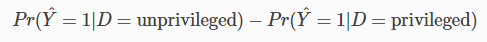


In [54]:
clf_metric.statistical_parity_difference()

-0.29796215389601427

### Balance
The balance test examine whether the average score received by individuals in positive and negative instances are similar regardless of their protected attributes.

In [55]:
# Add prediction probability to dataframe for balance calculation 
bias_detect_df['pred_prob'] = res_x_prob_pred
bias_detect_df.head()

,state,poverty,ur,metro,h6,mbrs,race_eth,sex,ainc5000,brdn,sec_8,pred,pred_prob
3580,4,4,1,0,1,1,1,0,1,0,0,1,0.643750
35857,32,4,1,0,2,1,0,0,1,0,1,0,0.216523
36068,17,4,1,0,6,2,3,0,4,0,0,0,0.287713
78249,32,3,1,0,1,2,1,0,9,0,0,0,0.262041
15885,4,3,1,0,1,1,2,0,1,0,0,1,0.881217


#### Race
- 0: Black
- 1: Hispanic
- 2: Other
- 3: White

The model tends to assign a higher probability of section 8 housing classification scores to tenants who's race is defined as other.

Text(0.5, 1.0, 'Balance of Predictions for Each Race')

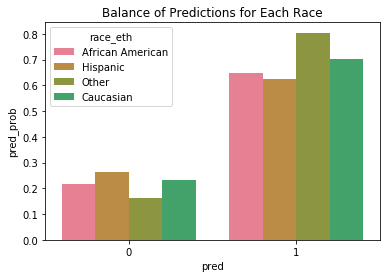

In [56]:
# Calculate the average prediction probability for each prediction and race 
avg_pred_prob = bias_detect_df.groupby(['race_eth','pred'])['pred_prob'].mean()
race_balance = pd.DataFrame(avg_pred_prob)
race_balance = race_balance.reset_index()

# Convert race from numeric to string
race_balance.loc[0:1,['race_eth']] = 'African American'
race_balance.loc[2:3,['race_eth']] = 'Hispanic'
race_balance.loc[4:5,['race_eth']] = 'Other'
race_balance.loc[6:7,['race_eth']] = 'Caucasian'

sns.barplot(x='pred',y='pred_prob',hue='race_eth',data=race_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Race')

#### Sex
- 0: Female
- 1: Male

The model tends to assign a higher probability of section 8 housing classification scores equally to women and men.

Text(0.5, 1.0, 'Balance of Predictions for Each Sex')

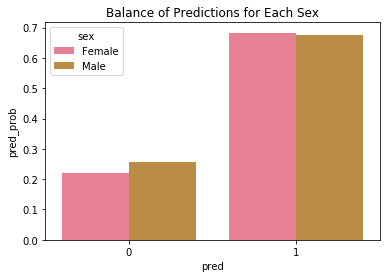

In [57]:
# Calculate the average prediction probability for each prediction and sex 
avg_pred_prob = bias_detect_df.groupby(['sex','pred'])['pred_prob'].mean()
sex_balance = pd.DataFrame(avg_pred_prob)
sex_balance = sex_balance.reset_index()

# Convert sex from numeric to string
sex_balance.loc[0:1,['sex']] = 'Female'
sex_balance.loc[2:3,['sex']] = 'Male'

sns.barplot(x='pred',y='pred_prob',hue='sex',data=sex_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Sex')

#### Poverty 
- 0: 0%-9%
- 1: 10%-19%
- 2: 20%-29%
- 3: 30%-39%
- 4: 40% and above

The model tends to assign a higher probability of section 8 housing classification scores to tenants who are in the very low poverty group. 

Text(0.5, 1.0, 'Balance of Predictions for Each Poverty Class')

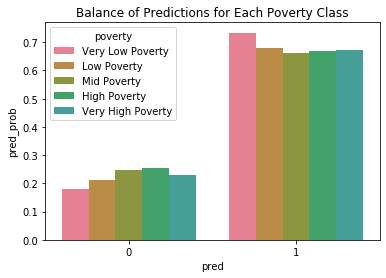

In [58]:
# Calculate the average prediction probability for each prediction and poverty group 
avg_pred_prob = bias_detect_df.groupby(['poverty','pred'])['pred_prob'].mean()
poverty_balance = pd.DataFrame(avg_pred_prob)
poverty_balance = poverty_balance.reset_index()

# Convert poverty from numeric to string
poverty_balance.loc[0:1,['poverty']] = 'Very Low Poverty'
poverty_balance.loc[2:3,['poverty']] = 'Low Poverty'
poverty_balance.loc[4:5,['poverty']] = 'Mid Poverty'
poverty_balance.loc[6:7,['poverty']] = 'High Poverty'
poverty_balance.loc[8:9,['poverty']] = 'Very High Poverty'

sns.barplot(x='pred',y='pred_prob',hue='poverty',data=poverty_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Poverty Class')

#### Urban or Rural
- 0: R
- 1: U

The model tends to assign a slightly higher probability of section 8 housing classification scores to tenants who are in the rural areas.

,ur,pred,pred_prob
0,0,0,0.225270
1,0,1,0.706652
2,1,0,0.229472
3,1,1,0.680188


Text(0.5, 1.0, 'Balance of Predictions for Each Area')

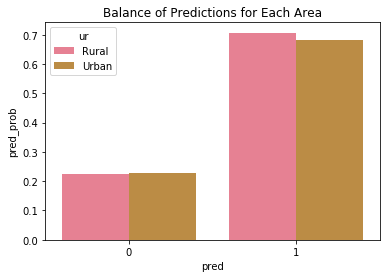

In [59]:
# Calculate the average prediction probability for each prediction and poverty group 
avg_pred_prob = bias_detect_df.groupby(['ur','pred'])['pred_prob'].mean()
ur_balance = pd.DataFrame(avg_pred_prob)
ur_balance = ur_balance.reset_index()

ur_balance.head(40)

# Convert poverty from numeric to string
ur_balance.loc[0:1,['ur']] = 'Rural'
ur_balance.loc[2:3,['ur']] = 'Urban'

sns.barplot(x='pred',y='pred_prob',hue='ur',data=ur_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Area')

#### Adjusted Household Income 
- 0: 0-2,500
- 1: 10,001-12,500
- 2: 12,501-15,000
- 3: 15,001-17,500
- 4: 17,501-20,000
- 5: 2,501-5,000
- 6: 20,001-25,000
- 7: 25,001-30,000
- 8: 30,001-40,000
- 9: 40,001-90,000
- 10: 5,001-7,500
- 11: 7,501-10,000

The model tends to assign a slightly higher probability of section 8 housing classification scores to tenants who make 0-2,5000 annually. 

Text(0.5, 1.0, 'Balance of Predictions for Each Income Level')

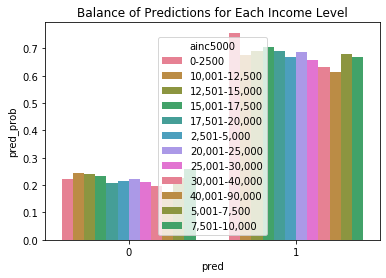

In [60]:
# Calculate the average prediction probability for each prediction and poverty group 
avg_pred_prob = bias_detect_df.groupby(['ainc5000','pred'])['pred_prob'].mean()
ainc5000_balance = pd.DataFrame(avg_pred_prob)
ainc5000_balance = ainc5000_balance.reset_index()

# ainc5000_balance.head(40)

# Convert poverty from numeric to string
ainc5000_balance.loc[0:1,['ainc5000']] = '0-2500'
ainc5000_balance.loc[2:3,['ainc5000']] = '10,001-12,500'
ainc5000_balance.loc[4:5,['ainc5000']] = '12,501-15,000'
ainc5000_balance.loc[6:7,['ainc5000']] = '15,001-17,500'
ainc5000_balance.loc[8:9,['ainc5000']] = '17,501-20,000'
ainc5000_balance.loc[10:11,['ainc5000']] = '2,501-5,000'
ainc5000_balance.loc[12:13,['ainc5000']] = '20,001-25,000'
ainc5000_balance.loc[14:15,['ainc5000']] = '25,001-30,000'
ainc5000_balance.loc[16:17,['ainc5000']] = '30,001-40,000'
ainc5000_balance.loc[18:19,['ainc5000']] = '40,001-90,000'
ainc5000_balance.loc[20:21,['ainc5000']] = '5,001-7,500'
ainc5000_balance.loc[22:23,['ainc5000']] = '7,501-10,000'

sns.barplot(x='pred',y='pred_prob',hue='ainc5000',data=ainc5000_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Income Level')

### Equal Opportunity Difference
Equal opportunity is the idea that all people are given an equitable chance in order to ensure fairness. Algorithms that lack equitable opportunities can exacerbate discrimination in already marginalized groups and can foster social exclusion. Using the difference in recall scores between unprivileged and privileged groups can calculate the equality of how the subclasses of protected attributes are treated by algorithms. 

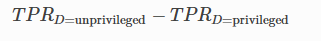

In [61]:
clf_metric.equal_opportunity_difference()

-0.2382749956460345

### Average Odds Difference
The average odds difference is the average of difference in false positive rates and true positive rates between unpriviliged and privileged groups. A value of 0 implies both groups have equal benefit. 

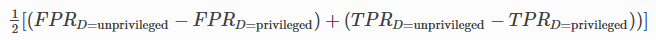

In [62]:
clf_metric.average_odds_difference()

-0.2450026549842635

## Individual Fairness

### Theil Index
The Theil index is a statistic used to measure economic inequality. The Theil index measures entropic distance the population is away from the ideal egalitarian state of everyone having the same income. the numerical result is in terms of negative entropy so that a higher number indicates more order that is further away from the ideal of maximum disorder. Forumulating the index to represent negative entropy instead of entropy allows it to be a measure of inequality rather than equality.

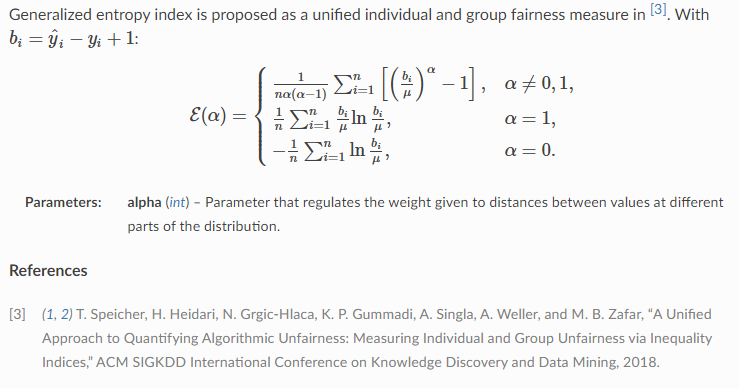

In [63]:
clf_metric.theil_index()

0.14221065496101393

### False Positive Rate
The false positive rate is the proportion of the individuals with a known negative condition for which the test result is positive. This rate is sometimes called the fall-out. 

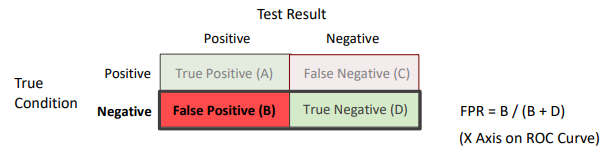

In [64]:
clf_metric.false_positive_rate()

0.3327861513206984

### False Negative Rate
The false negative rate is the proportion of the individuals with a known positive condition for which the testresult is negative. This rate is sometimes called the miss rate. 
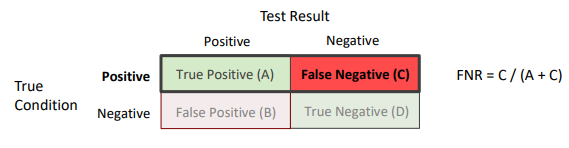

In [65]:
clf_metric.false_negative_rate()

0.285786217810387

### False Omission Rate
The false omission rate is the proportion of the individuals with a negative test result for which the true condition
is positive. 

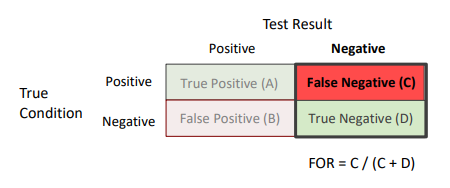

In [66]:
clf_metric.false_omission_rate()

0.1509039805530234

### False Discovery Rate
The false discovery rate is the proportion of the individuals with a positive test result for which the true condition is negative.

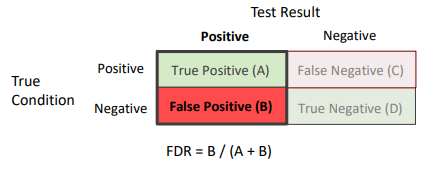

In [67]:
clf_metric.false_discovery_rate()

0.5289624745006879

### Error Rate
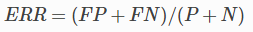

In [68]:
clf_metric.error_rate()

0.3190035226865231

### Accuracy
The accuracy reflects the total proportion of individuals that are correctly classified.

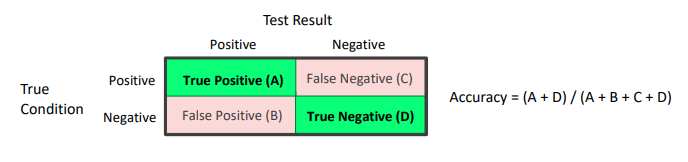

In [69]:
clf_metric.accuracy()

0.6809964773134769

### Differential Fairness Bias Amplification
Bias amplification is the difference in smoothed EDF between the classifier and the original dataset.

In [70]:
clf_metric.differential_fairness_bias_amplification()

0.22017927711743235

### Binary Confusion Matrix
Computes the number of true/false positives/negatives, optionally conditioned on protected attributes.



In [71]:
clf_metric.binary_confusion_matrix()

{'TP': 9929.0, 'FP': 11150.0, 'TN': 22355.0, 'FN': 3973.0}

## 9.1 Bias Identification Explanation
#### Fairness Metrics
From the results of the fairness assessments very few metrics stand out as overly biased. The disparate impact value is moderately low, indicating there is not an overt adverse effect on marginalized traits and that the model, for the most part, is behaving fairly. The four fifths and balance analysis however dig deeper into each protected attribute and the bias among the sub-classes.

#### Four Fifths Analysis
##### Race
The ratio of section 8 classifications made by the model for tenants of differing races does not pass the four fifths rule. There is a slight overt disparate race impact in the model that disproportionately affects tenants who are categorized as Hispanic, Caucasian, or African American. This may be due to a large portion of this dataset being populated by the Office of Public and Indian Housing. Typically, Native Americans are less represented in datasets of the entire population. However, with data that specifically accounts for the minority population, the effects of their representation is effecting the fairness assessment of the model. 

##### Sex
The ratio of section 8 classifications made by the model for men and women passes the four fifths rule. While one interpretation of this is that there may not be an overt disparate gender impact in the model, it's still important to document why this may be the case. This outcome in particular surprised me. As we saw earlier in the EDA section, women make up a large portion of the dataset. The model was able to successfully oversample the minority class and provide an equitable outcome for both men and women. 

##### Poverty 
The ratio of section 8 classifications made by the model for tenants of differing poverty levels does not pass the four fifths rule. There is an overt disparate poverty impact in the model that disproportionately affects tenants who have very high or high poverty levels. This outcome is especially alarming. The model has a hard time predicting section 8 housing tenants who are experiencing very high and high levels of poverty. Tenants who belong to these groups may be discriminated against based on their income. From having background knowledge of features that are typically highly correlated with protected attributes, income and poverty level can be proxies to race, age, sex, and more. 

##### Adjusted Household Income 
The ratio of section 8 classifications made by the model for tenants of differing adjusted household incomes does pass the four fifths rule. There is an overt income disparate impact in the model that disproportionately affects households that make 5,000-10,000, 12,500-17,500, and 30,000-90,000. annually. This outcome further shows that the model may be discriminating against tenants who are experiencing very low income level and high poverty. The outcome also shows that the model may be less accurate when predicting tenants who are among the highest income levels. This conclusion also supports one of my hypothesis that the model should be most accurate when predicting tenants who are among lower income groups. 

#### Balance Analysis 
##### Race
The model tends to assign a higher probability of section 8 housing classification scores to tenants who's race is defined as other. Again, this may be due to a large portion of this dataset being populated by the Office of Public and Indian Housing. The second highest race the model predicts for section 8 housing is Caucasian’s. This conclusion aligns with my hypothesis that the model may assign higher positive classes to the Caucasian race over other races due to the historical bias within the housing market. 

##### Sex
The model tends to assign a the probability of section 8 housing classification scores equally to women and men. Again, this conclusion surprises me. As we saw earlier in the EDA section, women make up a large portion of the dataset and I had hypothesized that the model would tend to positively classify women more than men.

##### Poverty 
The model tends to assign a higher probability of section 8 housing classification scores to tenants who are in the very low poverty group. This conclusion is interesting in relation to the outcomes observed in the four fifths analysis. While although the model is assigning a higher probability of section 8 classifications to very low income tenants, the amount of actual very low income tenants selected for section 8 housing is less than the model predicted. Meaning, tenants who are among those with high or very high poverty rates are not being prioritized by HUD when selecting who should be given section 8 housing vouchers.   

##### Adjusted Household Income 
The model tends to assign a slightly higher probability of section 8 housing classification scores to tenants who make 0-2,5000 annually. Again, this is a very interesting observation. The model should be selecting and prioritizing those who have very low income levels as section 8 housing tenants. However, as mentioned prior, the amount of very low income tenants selected for section 8 housing is less than the model is predicting. 

# 10. Mitigating Bias
To mitigate bias, I utilized an open-source toolkit/Python package of metrics and algorithms introduced by IBM Research in 2018. Bias mitigation algorithms can be generally categorized into three categories: pre-process (which affects the data, prior to training), in-process (which affects the classifier itself), and post-process (which affects the prediction labels that are output). 

Bias mitigation algorithms attempt to improve the fairness metrics by modifying the training data, the learning algorithm, or the predictions. These algorithm categories are known as pre-processing, in-processing, and post-processing, respectively. Bias mitigation algorithms attempt to improve algorithmic fairness by modifying the training data, the learning algorithm, or predictions. These algorithm categories are known as pre-processing, in-processing, and post-processing. Debiasing is a complex technique that cannot be applied for all problems in the same way. With the use of the pre, in, and post-processing debiasing techniques, comes with the risk of losing interpretability of the model. 


### Bias Mitigation with Pre-Processing
One approach for mitigating bias that some people often suggest is simply to remove the feature that should be protected. For example, if you are concerned of a model being sexist and you have gender available in your data set, remove it from the features passed to the machine learning algorithm. Unfortunately, this rarely fixes the problem. 

Pre-processing algorithms can be used to mitigate algorithmic bias. Pre-processing algorithms are applied prior to training the model. There are many pre-processing techniques but the most common and widely used are reweighing and applying a disparate impact remover. Reweighing is a technique that generates weights for labels differently to ensure fairness before fitting a classification model. The disparate impact remover is a variable repair technique. It modifies feature values to increase group fairness while preserving rank-ordering within groups.

In [72]:
# Disparate impact remover preprocessing 
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(bld_df)
transformed = dataset_transf_train.convert_to_dataframe()[0]

#### Retrain the SMOTE XGBoost Model

In [73]:
x_trans = transformed.drop(['sec_8'], axis = 1)
y_trans = transformed['sec_8']

scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)
X_trans_train,X_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y_trans, test_size=0.3, random_state = 42)

res_x_clf.fit(X_trans_train,y_trans_train)

# # Predict using test set
pre_res_x_pred = res_x_clf.predict(X_trans_test)
pre_res_x_prob_pred = res_x_clf.predict_proba(X_trans_test)[:,1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_metrics", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, eval_metrics='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=7.0, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=1.0,
              reg_lambda=0.1, scale_pos_weight=1, silent=False, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Model Evaluation Results: SMOTE XGBoost Model using PreProcessing Disparate Impact Remover Technique

,SMOTE XGBoost PreProcessing,SMOTE XGBoost
Accuracy,0.7259,0.6810
Sensitivity,0.3646,0.7142
Specificity,0.8756,0.6672
Precision Positive,0.5484,0.4710
Precision Negative,0.7689,0.8491
F1 Score Positive,0.4380,0.5677
F1 Score Negative,0.8188,0.7472


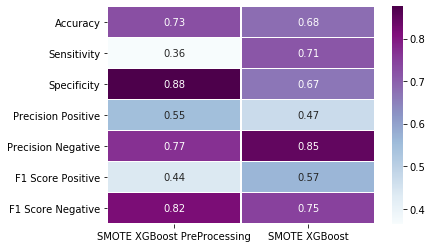

In [74]:
# Call model evaluation metrics
pre_results = model_eval(y_trans_test, pre_res_x_pred)
smote_x_results = model_eval(y_test, res_x_pred)

# Visualize model evaluation metrics in a heatmap 
results = pre_results
smote_xgbmodel = smote_x_results


viz = pd.DataFrame.from_dict(results, orient='index', columns=['SMOTE XGBoost PreProcessing'])
viz['SMOTE XGBoost'] = pd.DataFrame.from_dict(smote_xgbmodel, orient='index', columns=['SMOTE XGBoost'])

viz.head(10)
ax = sns.heatmap(viz,
                cmap = 'BuPu',
                linewidths = .5,
                annot = True)

#### Fairness Results: SMOTE XGBoost Model using PreProcessing Disparate Impact Remover Technique

In [75]:
# Construct the test dataframe 
trans_test_df = pd.DataFrame(X_trans_test)
trans_test_df['sec_8'] = y_trans_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=trans_test_df,
                            label_names=['sec_8'],
                            protected_attribute_names=['race_eth','sex'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = pre_res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'race_eth':0}] # African American 
privileged_groups = [{'race_eth':3}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
trans_clf_metric = ClassificationMetric(bld_df,
                                    bld_df_pred,
                                    unprivileged_groups,
                                    privileged_groups)

,Preprocessing SMOTE XGBoost Fairness Assessment,SMOTE XGBoost Fairness Assessment
Accuracy,0.725937,0.680996
Disparate Impact,0.306401,0.510025
Statistical Parity Difference,-0.218391,-0.297962
Equal Opportunity Difference,-0.252963,-0.238275
Average Odds Difference,-0.209609,-0.245003
Theil Index,0.238511,0.142211
False Positive Rate,0.124391,0.332786
False Negative Rate,0.635382,0.285786
False Omission Rate,0.231118,0.150904
False Discovery Rate,0.451625,0.528962


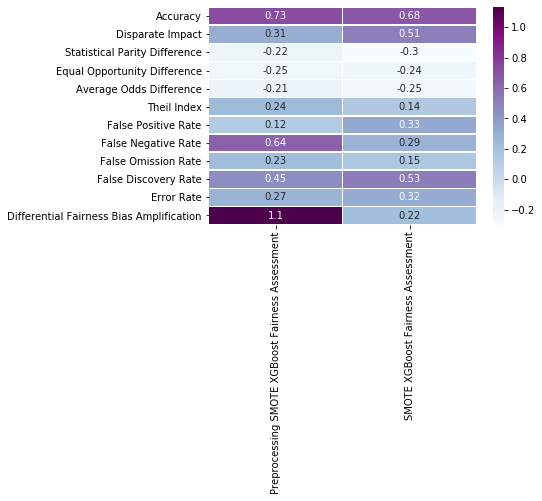

In [76]:
# Call fairness assessment metrics 
preproc_fair_assessment = fairness_bias_detection(trans_clf_metric)
fair_assessment = fairness_bias_detection(clf_metric)

fair_viz = pd.DataFrame.from_dict(preproc_fair_assessment, orient='index', columns=['Preprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'] = fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz['SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])
fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## 10.1 Preprocessing Bias Mitigation Results Explanation 
Preprocessing algorithms like the disparate impact remover are used to mitigate bias. From knowledge of bias within ML, a fairness through unawareness approach can never fully mitigate bias like an algorithm can. Fairness though unawareness is a technique where protected attributes like race, age, and sex are removed from the model. However, typically bias will still remain. The disparate impact remover preprocessing bias mitigation technique can be applied to the training data and used when fitting and predicting a new model. 

From understanding the results of applying the disparate impact remover to the newly trained ‘fair’ SMOTE XGBoost model, we can see the ‘fair’ model performs better in several of the model evaluation categories like overall accuracy and in predicting the negative class. However, the newly trained ‘fair’ model has a harder time predicting the positive class where the previous model excelled. This may come as an interesting conclusion. Logically it makes more sense if the ‘fair’ model performs better at every model evaluation category than the original model. However, there is a trade-off between accuracy and fairness. When algorithms are built for accuracy needs, they typically don’t pay mind to perpetuating potential bias. When algorithms are built with fairness in mind, they are less accurate than if they had exploited the bias. While although there is no right way to handle the accuracy and fairness trade off, there are tools that can help data scientists optimize their models for a level of accuracy and fairness they’re comfortable implementing.  

The fairness results of the ‘fair’ model and the original SMOTE XGBoost model indicate that the model’s fairness improved with the disparate impact remover technique. The disparate impact the model has on marginalized groups decreased, the overall accuracy increased, and many of the other metrics improved within the ‘fair’ model. However, there is still bias that remains, which we can see with the increase of the differential fairness bias amplification and Theil index. While although the fairness improved in some ways, it is ultimately a judgement call on which model to choose for final implementation. 


### Bias Mitigation with Post-Processing
Post-processing algorithms are bias mitigation strategies to build accurate performing models while ensuring models are less discriminant. Post-processing algorithms are applied after training the model. There are several post-processing techniques but the most used are the equalized odds post-processing and calibrated equalized odds post-processing techniques. The equalized odds technique solves a linear program to find probabilities with which to change output labels to optimize equalized odds. Calibrated equalized odds postprocessing optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

#### Calibrated Equalized Odds Post-Processing

In [79]:
# Construct the test dataframe 
test_df = pd.DataFrame(X_test)
test_df['sec_8'] = y_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['sec_8'],
                            protected_attribute_names=['race_eth','sex'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = res_x_pred

In [80]:
cost_constraint='weighted'
# Learn parameters to equalize odds and apply to create a new dataset
copost = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

copost = copost.fit(bld_df, bld_df_pred)
data_transf_test_pred = copost.predict(bld_df_pred)
post_res_x_pred=data_transf_test_pred.labels

#### Model Evaluation Results: SMOTE XGBoost Model using PostProcessing Calibrated Equalized Odds Technique

In [81]:
# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['sec_8'],
                            protected_attribute_names=['race_eth','sex'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = post_res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'race_eth':0}] # African American 
privileged_groups = [{'race_eth':3}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
post_clf_metric = ClassificationMetric(bld_df,
                                        bld_df_pred,
                                        unprivileged_groups,
                                        privileged_groups)

,Postprocessing SMOTE XGBoost Fairness Assessment,Preprocessing SMOTE XGBoost Fairness Assessment,SMOTE XGBoost Fairness Assessment
Accuracy,0.916278,0.725937,0.680996
Disparate Impact,0.603583,0.306401,0.510025
Statistical Parity Difference,-0.147537,-0.218391,-0.297962
Equal Opportunity Difference,0.000000,-0.252963,-0.238275
Average Odds Difference,0.000000,-0.209609,-0.245003
Theil Index,0.087435,0.238511,0.142211
False Positive Rate,0.000000,0.124391,0.332786
False Negative Rate,0.285498,0.635382,0.285786
False Omission Rate,0.105913,0.231118,0.150904
False Discovery Rate,0.000000,0.451625,0.528962


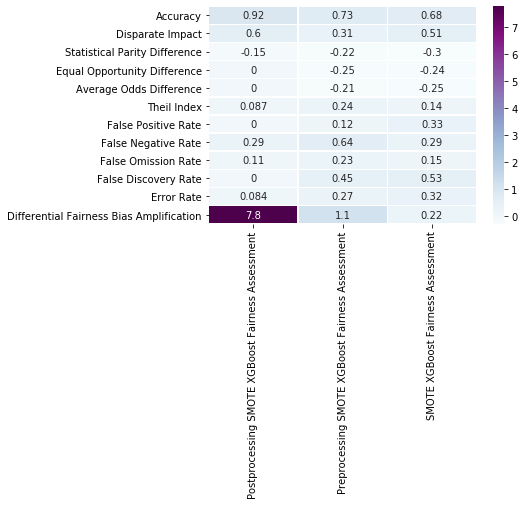

In [82]:
# Call fairness assessment metrics 
postproc_fair_assessment = fairness_bias_detection(post_clf_metric)

fair_viz = pd.DataFrame.from_dict(postproc_fair_assessment, orient='index', columns=['Postprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['Postprocessing SMOTE XGBoost Fairness Assessment'] = fair_viz['Postprocessing SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(preproc_fair_assessment, orient='index', columns=['Preprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])

fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## 10.2 Postprocessing Bias Mitigation Results Explanation
Postprocessing algorithms like the calibrated equalized odds technique are used to mitigate bias after a model has been trained. There is often debate surrounding which processing technique is better to use. Often, postprocessing techniques rarely remove bias from an already trained model and instead remove bias from the outcomes. Refer to Figure 8 on the next page. 
The results of applying the calibrated equalized odds postprocessing bias mitigation technique show that the postprocessing model improved overall accuracy, Theil index, false discovery rate, and false omission rate. However, it did not perform as well as the preprocessing ‘fair’ model or original SMOTE XGBoost model in differential fairness bias amplification or disparate impact. 

While although each technique improved model fairness, there is no concise answer as to which technique subjectively improved fairness overall. 


# 11. Explain Model Predictions
The first step in explaining the model's predictions is to create an explainer. We can use SHAP Tree explainer, which is the main explainer used for tabular data for tree based problems. SHAP uses feature importance and shapley values that are an adaptation of game theory.  SHAP scales and generates new data using locality and computes statistics like mean for numerical data and frequency for categorical data, due to this we need to pass our training data as a parameter.

In [83]:
# Explain predictions using the SHAP TreeExplainer
shap.initjs()
explainer = shap.TreeExplainer(res_x_clf)
shap_values = explainer.shap_values(X_res)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


#### Local Explainability: Visualize a Single Prediction 

In [84]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_res.iloc[0,:])

#### Local Explainability: Visualize 1,000 Predictions 

In [85]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_res.iloc[:1000,:])

#### Gloabl Explainability: Bar Chart Mean of Feature Importance

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


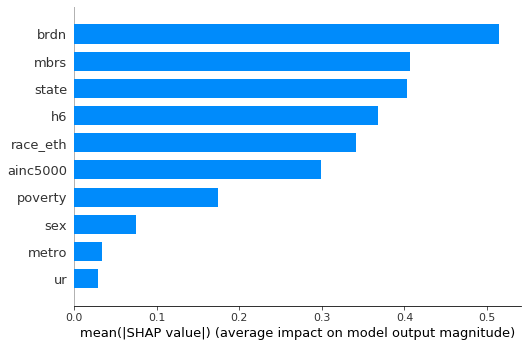

In [86]:
shap.summary_plot(shap_values, X_res, plot_type="bar")

#### Global Explainability: Summary Density Scatter Feature Importance
Rather than use a typical feature importance bar chart, we can use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

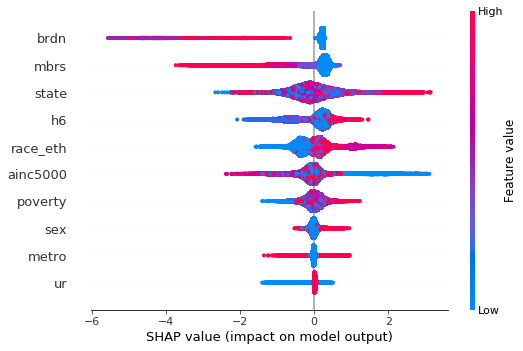

In [87]:
shap.summary_plot(shap_values, X_res)

#### Local Explainability: Dependence Plots
Dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


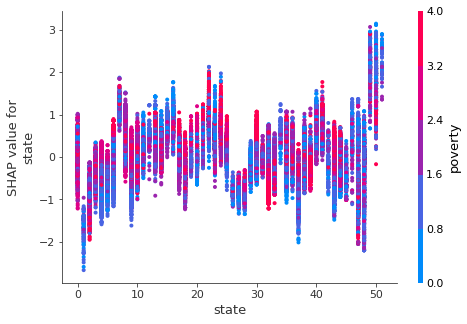

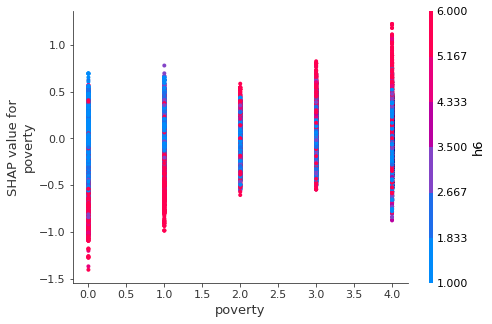

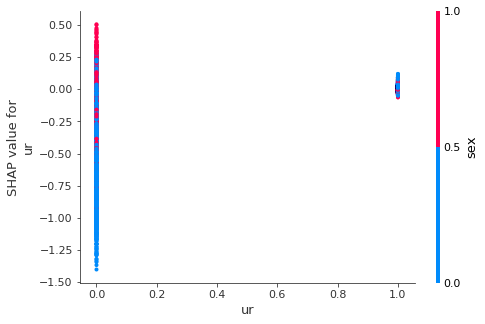

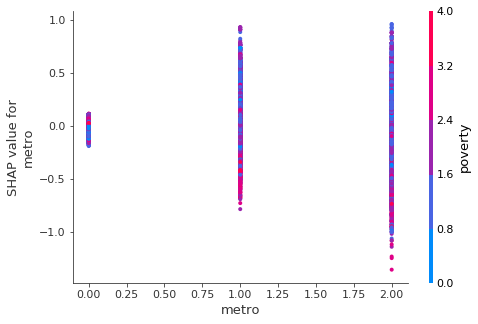

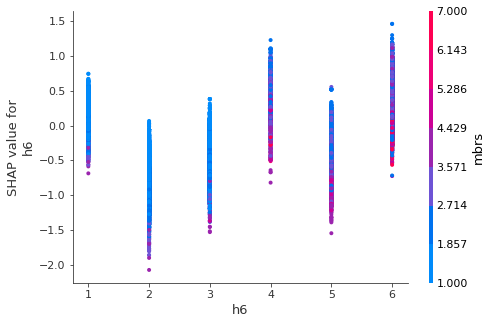

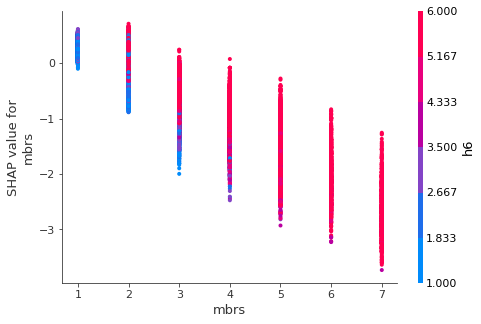

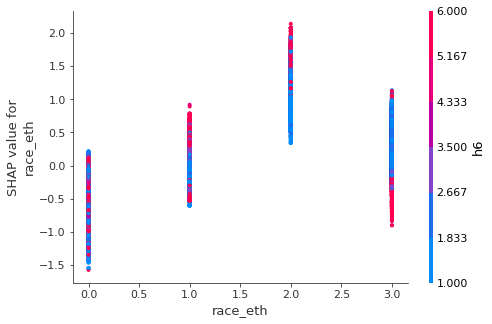

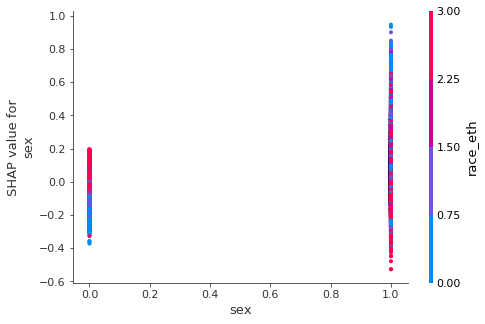

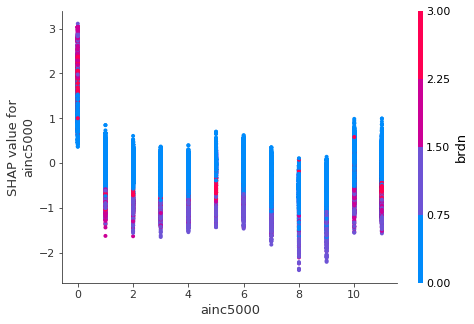

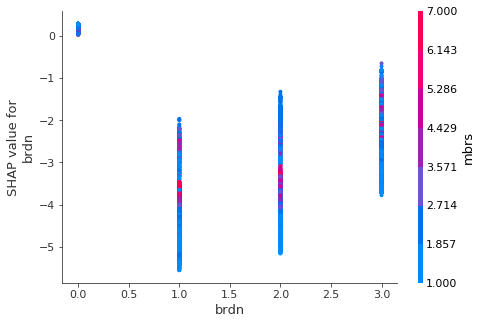

In [88]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_res, display_features=X_res)

In [89]:
explainer = shap.Explainer(res_x_clf, X_res)
shap_values = explainer(X_res[:1000])

 99%|===================| 988/1000 [00:54<00:00]        

#### Heatmap

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


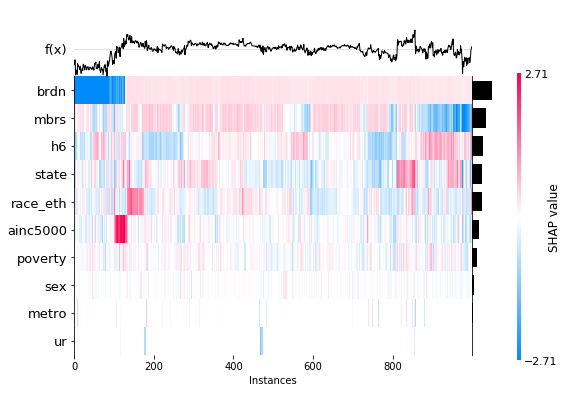

In [90]:
shap.plots.heatmap(shap_values, max_display=20)

#### Local Explainability: Dependence Scatter Plot

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


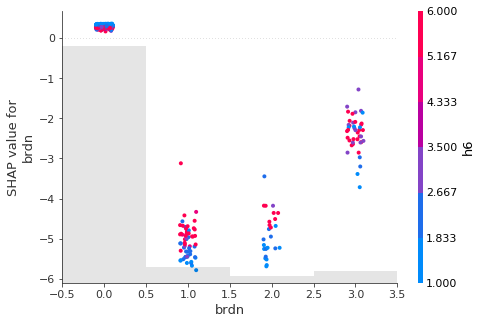

In [91]:
shap.plots.scatter(shap_values[:,'brdn'],color=shap_values)

#### Local Explainability: Waterfall Plot

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


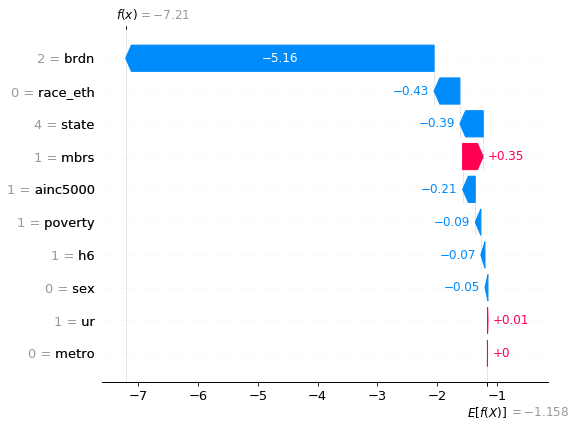

In [92]:
shap.plots.waterfall(shap_values[0])

## 11.1 Explain Interpetable Model Results
The goal of explainable AI is to ensure all participants in the ML model lifecycle can understand how AI algorithms and AI system make decisions. Often times, black box algorithms are used to derive insights. Algorithms vary from simple to understand and explain to complicated models. Which is why transparency into decision making is important. 

This force plot displays the explanation for one single tenant in the model. The red bars show the features and weight importance that drives the prediction value higher. While the blue bars show the features and their scores that drive the prediction value lower. Overall, the rent burden and adjusted household income features drive the prediction of the model for this individual. 

The summary plot displays the most important features to the model. Overall, the rent burden, the number of members in a household, and the state in which tenants live are the most important factors to explaining how the model makes decisions globally. As we saw from the previous plot, this does not indicate it will look the same for each individual. Individual predictions may look similar but not identical to the way the model interprets the most important features. 

# 12. Capstone Summary
The goal of this project was to detect bias by focusing on protected classes like race, sex, and other factors that could be proxies to protected attributes. From the EDA conducted on the HUD PUMS dataset, we saw that majority of tenants live well below the poverty line and affect female head of households disproportionately. My hypothesis was that based on historical evidence of discrimination towards minorities and women, that the model would display adverse outcomes against that part of the population. While although, there was not an overt gender or race impact in the model, there were other attributes that were adversely effected and potentially discriminated against. Tenants who live in extreme poverty and have very low income were overpredicted as being tenants of section 8 housing, when in reality they were not selected for the housing program. The model, while it predicted fairly, showed that the actual results were not fairly derived. 

The year of 2020 was an anomaly. We changed our ways of living due to the pandemic. Many folks are working from home and many have lost their jobs. Public transportation and public businesses, like restaurants and stores, have changed how they operate from reduced to capacity to closing down completely. While although there has been an increasing need for affordable housing, I believe the effects of the pandemic may’ve affected the fairness assessment of the model. Bias may be undetected because of the recent climate of the economy and world state. The pandemic has been hard for everyone. I suspected the pandemic would hit minorities and women harder than other portions of the population. However, from the results of the fairness assessment, they were not disproportionately impacted as I originally hypothesized. 

A fairness assessment may be better suited for housing data prior to the selection process of selecting section 8 prospects. There may be bias in the underlying way the government selects those who receive or don’t receive housing vouchers. This is data I could not find. However, based on the results of the bias identification phase, it  may be important to get an understanding of how candidates are selected. 
